# First Model Experiments

In this notebook I have made the first model experiments to have a baseline to start from. The objectives of this notebook are: 
* Deriving a data preparation procedure
* Define the models and metrics to use
* Track experiments and set up a model registry with MLFlow
* Saving a first draft of the models

In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, f1_score

import xgboost as xgb

import optuna

import mlflow
from mlflow.tracking import MlflowClient

import pickle

In [2]:
RANDOM_STATE = 2024

MLFLOW_TRACKING_URI = "sqlite:///../bank_churn.db"

In [3]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("bank_churn_prediction")

2024/07/22 12:22:04 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/07/22 12:22:04 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>

To launch mlflow, execute the following command in your terminal: 

mlflow server --backend-store-uri sqlite:///bank_churn.db --default-artifact-root ./artifacts

### Data Preparation

In [4]:
data = pd.read_parquet('../data/customer_churn_records.parquet')

In [5]:
data.drop(['RowNumber','CustomerId','Surname'], 
          axis = 1, inplace = True)

categorical_variables = ['Geography', 'Gender', 'Card Type']
target = 'Exited'
isf_variables = [target, 'Age','CreditScore','NumOfProducts'] 

data[categorical_variables] = data[categorical_variables].astype('category')

In [6]:
test_size = 0.2

train_data, val_data = train_test_split(data, test_size=test_size, random_state=RANDOM_STATE)


The following cell has only been used once to save data and it's not necessary to run it again. 


In [7]:
# train_data.to_parquet('../data/customer_churn_training_data.parquet', engine="pyarrow")
# val_data.to_parquet('../data/customer_churn_validation_data.parquet', engine="pyarrow")

### Model Experiments - Anomaly Detection

In [7]:
def objective_isf(trial):
    
    with mlflow.start_run(run_name = "anomaly_detection"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "isolation_forest")
    
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
            'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
            'max_features': trial.suggest_int('max_features', 1, 4),
            'bootstrap': True,
            'warm_start': True,
            'random_state': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        isf = IsolationForest(**params)
        isf.fit(train_data[isf_variables])
        
        anomalies = isf.predict(val_data[isf_variables])
        
        pct_returning, pct_inliers = compute_isf_metrics(val_data[isf_variables], anomalies)
        score = (1 - pct_returning)*(1 - pct_inliers)
        
        mlflow.log_metric("pct_returning", pct_returning)
        mlflow.log_metric("pct_inliers", pct_inliers)
        mlflow.log_metric("score", score)
        
        mlflow.sklearn.log_model(isf, artifact_path="mlflow_models")
    
    return score

def compute_isf_metrics(val_data, anomalies):
    
    val_data['Anomalies'] = anomalies
    
    pct_returning = len(val_data[(val_data['Anomalies']==1) & (val_data[target]==0)])/len(val_data[val_data['Anomalies']==1])
    pct_inliers = len(val_data[val_data['Anomalies']==1])/len(anomalies)
    
    return pct_returning, pct_inliers

In [8]:
study_isf = optuna.create_study(direction='minimize') 
study_isf.optimize(objective_isf, n_trials=50) 

[I 2024-07-22 12:22:35,840] A new study created in memory with name: no-name-5a8b3dc9-a6f8-453c-80b1-1f926d5a2927
/tmp/ipykernel_8565/1553850151.py:9: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 500, 10),
/tmp/ipykernel_8565/1553850151.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'contamination': trial.suggest_discrete_uniform('contamination', 0.05, 0.5, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_8565/1553850151.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [9]:
isf=IsolationForest(**study_isf.best_params)

isf.fit(train_data[isf_variables])

/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.4, max_features=2)

In [10]:
# With these parameters found in a couple of trials I obtained the best score
# n_estimators=150, 
# max_samples='auto', 
# contamination=0.45,
# max_features=1.0,
# bootstrap = True, 
# warm_start = True,
# random_state=RANDOM_STATE

In [11]:
anomalies = isf.predict(val_data[isf_variables])

data_anom = val_data.copy()
data_anom['Anomalies'] = anomalies
data_anom

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Anomalies
8374,628,Spain,Female,55,7,0.00,3,1,0,85890.75,1,1,3,DIAMOND,791,-1
6935,670,France,Male,33,1,0.00,2,1,1,86413.11,0,0,3,DIAMOND,898,1
5103,783,Germany,Female,58,3,127539.30,1,1,1,96590.39,1,1,5,SILVER,270,-1
8963,741,France,Male,52,1,171236.30,2,0,0,21834.40,1,1,5,PLATINUM,332,-1
4993,554,France,Female,44,6,92436.86,1,1,0,126033.90,0,0,4,GOLD,938,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,702,Spain,Female,26,4,135219.57,1,0,1,59747.63,0,0,4,DIAMOND,267,1
8073,777,Germany,Female,34,5,96693.66,1,1,1,172618.52,0,0,2,SILVER,971,1
3673,764,France,Male,24,7,98148.61,1,1,0,26843.76,0,0,1,GOLD,275,-1
8208,711,France,Female,29,3,130181.47,2,1,0,31811.44,0,0,5,SILVER,719,1


<AxesSubplot:xlabel='Exited', ylabel='Count'>

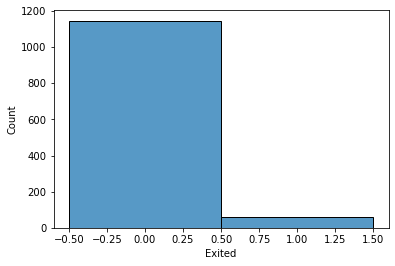

In [12]:
sns.histplot(data_anom[data_anom['Anomalies']==1][target], discrete=True)

<AxesSubplot:xlabel='Exited', ylabel='Count'>

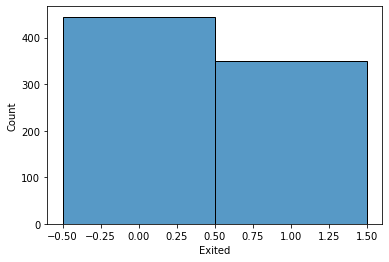

In [13]:
sns.histplot(data_anom[data_anom['Anomalies']==-1][target], discrete=True)

After applying anomaly detection, the dataset is not unbalanced anymore. Furthermore, we can already filter more than 40% of customers by setting a big chunk of returning customers on the side. 

<AxesSubplot:xlabel='Age', ylabel='Count'>

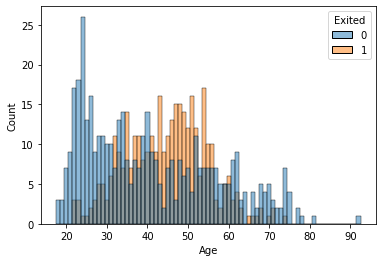

In [14]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='Age', ylabel='Count'>

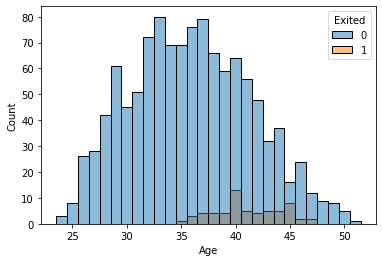

In [15]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='Age', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

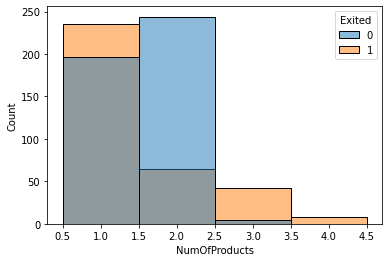

In [16]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Count'>

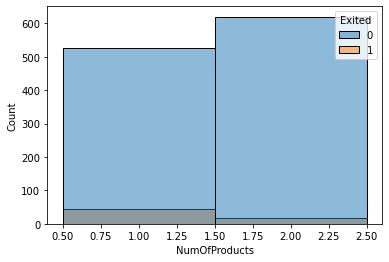

In [17]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='NumOfProducts', hue=target, discrete=True)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

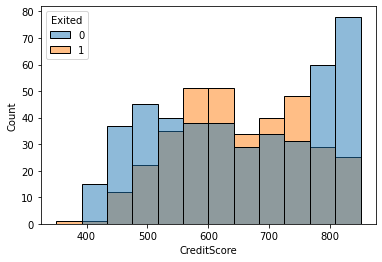

In [18]:
sns.histplot(data=data_anom[data_anom['Anomalies']==-1], x='CreditScore', hue=target)

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

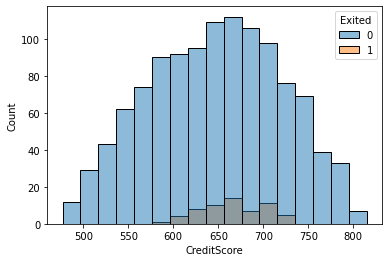

In [19]:
sns.histplot(data=data_anom[data_anom['Anomalies']==1], x='CreditScore', hue=target)

We can see how Isolation Forests also level out the most irregular distributions.

In [22]:
with open('../models/isolation_forest.bin', 'wb') as f_out:
    pickle.dump(isf, f_out)

In [23]:
mlflow.log_artifact("../models/isolation_forest.bin", artifact_path="isolation_forest")

In [24]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[]

In [25]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/0', creation_time=1721650927455, experiment_id='0', last_update_time=1721650927455, lifecycle_stage='active', name='Default', tags={}>]

In [27]:
study_isf.best_trial.number

5

In [30]:
study_isf.best_params

{'n_estimators': 100, 'contamination': 0.4, 'max_features': 2}

In [35]:
run_id = client.search_runs(experiment_ids=["1"])[50-study_isf.best_trial.number].info.run_id

In [36]:
#run_id = 'a81512e7ee184ef98b923cb89a712120' #Found on MLFlow UI

mlflow.register_model(
    model_uri=f"runs:/{run_id}/isolation_forest",
    name='isolation_forest'
)

Registered model 'isolation_forest' already exists. Creating a new version of this model...
Created version '1' of model 'isolation_forest'.


<ModelVersion: aliases=[], creation_timestamp=1721651499384, current_stage='None', description=None, last_updated_timestamp=1721651499384, name='isolation_forest', run_id='69e0a17554474392b877fa0ba5b70d21', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/69e0a17554474392b877fa0ba5b70d21/artifacts/isolation_forest', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [37]:
mlflow.end_run()

### Model Experiments - XGBoost

In [38]:
X_train = train_data.drop(target, axis=1)
y_train = train_data[target]

X_val = val_data.drop(target, axis=1)
y_val = val_data[target]

In [39]:
train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [40]:
def objective_xgb(trial):
    
    with mlflow.start_run(run_name = "xgboost_classifier"):
        mlflow.set_tag("Project", "bank_churn_prediction")
        mlflow.set_tag("Developer", "Francesca")
        mlflow.set_tag("Model", "xgboost")
        
        params = {
            'objective': 'binary:logistic',
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
            'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
            'max_depth': trial.suggest_int('max_depth', 2, 100),
            'seed': RANDOM_STATE
        }
        
        mlflow.log_params(params)

        classifier = xgb.train(
                params = params,
                dtrain = train_matrix,
                num_boost_round = 1000,
                evals=[(val_matrix, 'validation')],
                early_stopping_rounds = 50
            )

        y_pred = np.rint(classifier.predict(val_matrix))

        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        mlflow.xgboost.log_model(classifier, artifact_path="mlflow_models")
    
    return recall 

In [41]:
study_xgb = optuna.create_study(direction='maximize') 
study_xgb.optimize(objective_xgb, n_trials=50) 

[I 2024-07-22 12:31:47,893] A new study created in memory with name: no-name-fbf94a53-5704-4f75-87c7-bb7cce826fee
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_8565/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),


[0]	validation-logloss:0.43795
[1]	validation-logloss:0.38406
[2]	validation-logloss:0.34059
[3]	validation-logloss:0.30431
[4]	validation-logloss:0.27337
[5]	validation-logloss:0.24660
[6]	validation-logloss:0.22319
[7]	validation-logloss:0.20255
[8]	validation-logloss:0.18425
[9]	validation-logloss:0.16795
[10]	validation-logloss:0.15337
[11]	validation-logloss:0.14027
[12]	validation-logloss:0.12847
[13]	validation-logloss:0.11784
[14]	validation-logloss:0.10821
[15]	validation-logloss:0.09949
[16]	validation-logloss:0.09158
[17]	validation-logloss:0.08440
[18]	validation-logloss:0.07787
[19]	validation-logloss:0.07192
[20]	validation-logloss:0.06651
[21]	validation-logloss:0.06152


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation-logloss:0.05699
[23]	validation-logloss:0.05284
[24]	validation-logloss:0.04905
[25]	validation-logloss:0.04559
[26]	validation-logloss:0.04243
[27]	validation-logloss:0.03954
[28]	validation-logloss:0.03689
[29]	validation-logloss:0.03447
[30]	validation-logloss:0.03226
[31]	validation-logloss:0.03021
[32]	validation-logloss:0.02838
[33]	validation-logloss:0.02668
[34]	validation-logloss:0.02513
[35]	validation-logloss:0.02374
[36]	validation-logloss:0.02244
[37]	validation-logloss:0.02119
[38]	validation-logloss:0.02013
[39]	validation-logloss:0.01916
[40]	validation-logloss:0.01823
[41]	validation-logloss:0.01743
[42]	validation-logloss:0.01670
[43]	validation-logloss:0.01604
[44]	validation-logloss:0.01542
[45]	validation-logloss:0.01483
[46]	validation-logloss:0.01434
[47]	validation-logloss:0.01388
[48]	validation-logloss:0.01347
[49]	validation-logloss:0.01310
[50]	validation-logloss:0.01277
[51]	validation-logloss:0.01246
[52]	validation-logloss:0.01217
[53]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:31:50,641] Trial 0 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 670, 'learning_rate': 0.0824259506143034, 'subsample': 1.0, 'max_depth': 26}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.46731
[1]	validation-logloss:0.43185
[2]	validation-logloss:0.40086
[3]	validation-logloss:0.37344
[4]	validation-logloss:0.34891
[5]	validation-logloss:0.32674
[6]	validation-logloss:0.30666
[7]	validation-logloss:0.28822
[8]	validation-logloss:0.27133
[9]	validation-logloss:0.25583
[10]	validation-logloss:0.24143
[11]	validation-logloss:0.22803
[12]	validation-logloss:0.21559
[13]	validation-logloss:0.20401
[14]	validation-logloss:0.19323
[15]	validation-logloss:0.18314
[16]	validation-logloss:0.17363
[17]	validation-logloss:0.16471
[18]	validation-logloss:0.15631
[19]	validation-logloss:0.14846
[20]	validation-logloss:0.14108
[21]	validation-logloss:0.13407
[22]	validation-logloss:0.12747
[23]	validation-logloss:0.12131
[24]	validation-logloss:0.11545


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation-logloss:0.10991
[26]	validation-logloss:0.10471
[27]	validation-logloss:0.09977
[28]	validation-logloss:0.09514
[29]	validation-logloss:0.09073
[30]	validation-logloss:0.08654
[31]	validation-logloss:0.08260
[32]	validation-logloss:0.07884
[33]	validation-logloss:0.07528
[34]	validation-logloss:0.07193
[35]	validation-logloss:0.06874
[36]	validation-logloss:0.06573
[37]	validation-logloss:0.06288
[38]	validation-logloss:0.06017
[39]	validation-logloss:0.05762
[40]	validation-logloss:0.05520
[41]	validation-logloss:0.05288
[42]	validation-logloss:0.05071
[43]	validation-logloss:0.04862
[44]	validation-logloss:0.04662
[45]	validation-logloss:0.04472
[46]	validation-logloss:0.04295
[47]	validation-logloss:0.04125
[48]	validation-logloss:0.03964
[49]	validation-logloss:0.03814
[50]	validation-logloss:0.03668
[51]	validation-logloss:0.03532
[52]	validation-logloss:0.03400
[53]	validation-logloss:0.03279
[54]	validation-logloss:0.03163
[55]	validation-logloss:0.03051
[56]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:31:53,699] Trial 1 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 930, 'learning_rate': 0.047567050611024765, 'subsample': 0.55, 'max_depth': 53}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.16952
[1]	validation-logloss:0.09418
[2]	validation-logloss:0.05506
[3]	validation-logloss:0.03431
[4]	validation-logloss:0.02292
[5]	validation-logloss:0.01687
[6]	validation-logloss:0.01398
[7]	validation-logloss:0.01188
[8]	validation-logloss:0.01161
[9]	validation-logloss:0.01065
[10]	validation-logloss:0.01085
[11]	validation-logloss:0.01098
[12]	validation-logloss:0.01055
[13]	validation-logloss:0.01098
[14]	validation-logloss:0.01093
[15]	validation-logloss:0.01086
[16]	validation-logloss:0.01082
[17]	validation-logloss:0.01101
[18]	validation-logloss:0.01078
[19]	validation-logloss:0.01084
[20]	validation-logloss:0.01071
[21]	validation-logloss:0.01093
[22]	validation-logloss:0.01050
[23]	validation-logloss:0.01083
[24]	validation-logloss:0.01077
[25]	validation-logloss:0.01108
[26]	validation-logloss:0.01134
[27]	validation-logloss:0.01121
[28]	validation-logloss:0.01156
[29]	validation-logloss:0.01144
[30]	validation-logloss:0.01155
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[58]	validation-logloss:0.01158
[59]	validation-logloss:0.01177
[60]	validation-logloss:0.01183
[61]	validation-logloss:0.01182
[62]	validation-logloss:0.01213
[63]	validation-logloss:0.01198
[64]	validation-logloss:0.01174
[65]	validation-logloss:0.01165
[66]	validation-logloss:0.01171
[67]	validation-logloss:0.01165
[68]	validation-logloss:0.01158
[69]	validation-logloss:0.01169
[70]	validation-logloss:0.01171
[71]	validation-logloss:0.01181
[72]	validation-logloss:0.01183


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:31:56,035] Trial 2 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 220, 'learning_rate': 0.5519337123153522, 'subsample': 0.45, 'max_depth': 31}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.44335
[1]	validation-logloss:0.39258
[2]	validation-logloss:0.35092
[3]	validation-logloss:0.31584
[4]	validation-logloss:0.28566
[5]	validation-logloss:0.25936
[6]	validation-logloss:0.23630
[7]	validation-logloss:0.21574
[8]	validation-logloss:0.19748
[9]	validation-logloss:0.18121
[10]	validation-logloss:0.16649
[11]	validation-logloss:0.15313
[12]	validation-logloss:0.14108
[13]	validation-logloss:0.13015
[14]	validation-logloss:0.12026
[15]	validation-logloss:0.11123
[16]	validation-logloss:0.10291
[17]	validation-logloss:0.09530
[18]	validation-logloss:0.08833
[19]	validation-logloss:0.08199
[20]	validation-logloss:0.07625
[21]	validation-logloss:0.07084
[22]	validation-logloss:0.06590
[23]	validation-logloss:0.06139
[24]	validation-logloss:0.05722
[25]	validation-logloss:0.05338
[26]	validation-logloss:0.04984
[27]	validation-logloss:0.04662
[28]	validation-logloss:0.04373
[29]	validation-logloss:0.04102
[30]	validation-logloss:0.03848
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.01582
[49]	validation-logloss:0.01533
[50]	validation-logloss:0.01487
[51]	validation-logloss:0.01449
[52]	validation-logloss:0.01406
[53]	validation-logloss:0.01368
[54]	validation-logloss:0.01335
[55]	validation-logloss:0.01305
[56]	validation-logloss:0.01275
[57]	validation-logloss:0.01252
[58]	validation-logloss:0.01228
[59]	validation-logloss:0.01209
[60]	validation-logloss:0.01184
[61]	validation-logloss:0.01169
[62]	validation-logloss:0.01155
[63]	validation-logloss:0.01145
[64]	validation-logloss:0.01132
[65]	validation-logloss:0.01123
[66]	validation-logloss:0.01115
[67]	validation-logloss:0.01104
[68]	validation-logloss:0.01098
[69]	validation-logloss:0.01090
[70]	validation-logloss:0.01082
[71]	validation-logloss:0.01072
[72]	validation-logloss:0.01067
[73]	validation-logloss:0.01063
[74]	validation-logloss:0.01060
[75]	validation-logloss:0.01058
[76]	validation-logloss:0.01052
[77]	validation-logloss:0.01043
[78]	validation-logloss:0.01043
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:31:58,665] Trial 3 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 840, 'learning_rate': 0.07600967714207321, 'subsample': 0.55, 'max_depth': 39}. Best is trial 0 with value: 0.9975550122249389.


[0]	validation-logloss:0.44130


/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1),
/tmp/ipykernel_8565/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:58] WARNING: /workspace/src/learner.cc:

[1]	validation-logloss:0.38925
[2]	validation-logloss:0.34685
[3]	validation-logloss:0.31131
[4]	validation-logloss:0.28083
[5]	validation-logloss:0.25430
[6]	validation-logloss:0.23121
[7]	validation-logloss:0.21057
[8]	validation-logloss:0.19238
[9]	validation-logloss:0.17612
[10]	validation-logloss:0.16151
[11]	validation-logloss:0.14826
[12]	validation-logloss:0.13620
[13]	validation-logloss:0.12531
[14]	validation-logloss:0.11556
[15]	validation-logloss:0.10668
[16]	validation-logloss:0.09862
[17]	validation-logloss:0.09117
[18]	validation-logloss:0.08437
[19]	validation-logloss:0.07818
[20]	validation-logloss:0.07248
[21]	validation-logloss:0.06723
[22]	validation-logloss:0.06248
[23]	validation-logloss:0.05816
[24]	validation-logloss:0.05417
[25]	validation-logloss:0.05049
[26]	validation-logloss:0.04711
[27]	validation-logloss:0.04403
[28]	validation-logloss:0.04117
[29]	validation-logloss:0.03859
[30]	validation-logloss:0.03621
[31]	validation-logloss:0.03412
[32]	validation-l

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:31:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:01,577] Trial 4 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 760, 'learning_rate': 0.07866807855636083, 'subsample': 0.35000000000000003, 'max_depth': 31}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.50248
[1]	validation-logloss:0.49601
[2]	validation-logloss:0.48971
[3]	validation-logloss:0.48359
[4]	validation-logloss:0.47759
[5]	validation-logloss:0.47170
[6]	validation-logloss:0.46600
[7]	validation-logloss:0.46039
[8]	validation-logloss:0.45493
[9]	validation-logloss:0.44957
[10]	validation-logloss:0.44432
[11]	validation-logloss:0.43915
[12]	validation-logloss:0.43407
[13]	validation-logloss:0.42910
[14]	validation-logloss:0.42427
[15]	validation-logloss:0.41952
[16]	validation-logloss:0.41486
[17]	validation-logloss:0.41028
[18]	validation-logloss:0.40576
[19]	validation-logloss:0.40134
[20]	validation-logloss:0.39697
[21]	validation-logloss:0.39270
[22]	validation-logloss:0.38848
[23]	validation-logloss:0.38434
[24]	validation-logloss:0.38028
[25]	validation-logloss:0.37627
[26]	validation-logloss:0.37235
[27]	validation-logloss:0.36845
[28]	validation-logloss:0.36462
[29]	validation-logloss:0.36087
[30]	validation-logloss:0.35719
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation-logloss:0.34647
[34]	validation-logloss:0.34297
[35]	validation-logloss:0.33953
[36]	validation-logloss:0.33617
[37]	validation-logloss:0.33285
[38]	validation-logloss:0.32956
[39]	validation-logloss:0.32633
[40]	validation-logloss:0.32317
[41]	validation-logloss:0.32001
[42]	validation-logloss:0.31692
[43]	validation-logloss:0.31387
[44]	validation-logloss:0.31083
[45]	validation-logloss:0.30785
[46]	validation-logloss:0.30489
[47]	validation-logloss:0.30197
[48]	validation-logloss:0.29910
[49]	validation-logloss:0.29625
[50]	validation-logloss:0.29345
[51]	validation-logloss:0.29070
[52]	validation-logloss:0.28799
[53]	validation-logloss:0.28530
[54]	validation-logloss:0.28266
[55]	validation-logloss:0.28006
[56]	validation-logloss:0.27750
[57]	validation-logloss:0.27495
[58]	validation-logloss:0.27243
[59]	validation-logloss:0.26994
[60]	validation-logloss:0.26747
[61]	validation-logloss:0.26503
[62]	validation-logloss:0.26264
[63]	validation-logloss:0.26028
[64]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:07,405] Trial 5 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 700, 'learning_rate': 0.00743380005501385, 'subsample': 0.2, 'max_depth': 25}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.26265
[1]	validation-logloss:0.17413
[2]	validation-logloss:0.11982
[3]	validation-logloss:0.08464
[4]	validation-logloss:0.06098
[5]	validation-logloss:0.04487
[6]	validation-logloss:0.03416
[7]	validation-logloss:0.02647
[8]	validation-logloss:0.02157
[9]	validation-logloss:0.01850
[10]	validation-logloss:0.01600
[11]	validation-logloss:0.01423
[12]	validation-logloss:0.01292
[13]	validation-logloss:0.01222
[14]	validation-logloss:0.01197
[15]	validation-logloss:0.01151
[16]	validation-logloss:0.01106
[17]	validation-logloss:0.01078
[18]	validation-logloss:0.01082
[19]	validation-logloss:0.01082
[20]	validation-logloss:0.01071
[21]	validation-logloss:0.01075
[22]	validation-logloss:0.01054
[23]	validation-logloss:0.01042
[24]	validation-logloss:0.01025
[25]	validation-logloss:0.01027
[26]	validation-logloss:0.01026
[27]	validation-logloss:0.01033
[28]	validation-logloss:0.01047
[29]	validation-logloss:0.01053
[30]	validation-logloss:0.01048
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.01014
[50]	validation-logloss:0.01029
[51]	validation-logloss:0.01016
[52]	validation-logloss:0.00997
[53]	validation-logloss:0.00999
[54]	validation-logloss:0.01011
[55]	validation-logloss:0.00998
[56]	validation-logloss:0.00996
[57]	validation-logloss:0.01026
[58]	validation-logloss:0.01025
[59]	validation-logloss:0.01041
[60]	validation-logloss:0.01048
[61]	validation-logloss:0.01085
[62]	validation-logloss:0.01089
[63]	validation-logloss:0.01094
[64]	validation-logloss:0.01090
[65]	validation-logloss:0.01103
[66]	validation-logloss:0.01121
[67]	validation-logloss:0.01112
[68]	validation-logloss:0.01120
[69]	validation-logloss:0.01124
[70]	validation-logloss:0.01117
[71]	validation-logloss:0.01144
[72]	validation-logloss:0.01144
[73]	validation-logloss:0.01135
[74]	validation-logloss:0.01135
[75]	validation-logloss:0.01123
[76]	validation-logloss:0.01130
[77]	validation-logloss:0.01141
[78]	validation-logloss:0.01145
[79]	validation-logloss:0.01129
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:09,866] Trial 6 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 10, 'learning_rate': 0.3386393223620671, 'subsample': 0.45, 'max_depth': 73}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=

[0]	validation-logloss:0.43440
[1]	validation-logloss:0.37864
[2]	validation-logloss:0.33398
[3]	validation-logloss:0.29693
[4]	validation-logloss:0.26543
[5]	validation-logloss:0.23834
[6]	validation-logloss:0.21485
[7]	validation-logloss:0.19411
[8]	validation-logloss:0.17593
[9]	validation-logloss:0.15981
[10]	validation-logloss:0.14540
[11]	validation-logloss:0.13247
[12]	validation-logloss:0.12090
[13]	validation-logloss:0.11054
[14]	validation-logloss:0.10123
[15]	validation-logloss:0.09282
[16]	validation-logloss:0.08516
[17]	validation-logloss:0.07822
[18]	validation-logloss:0.07191
[19]	validation-logloss:0.06624
[20]	validation-logloss:0.06119
[21]	validation-logloss:0.05643
[22]	validation-logloss:0.05213
[23]	validation-logloss:0.04823
[24]	validation-logloss:0.04471
[25]	validation-logloss:0.04148
[26]	validation-logloss:0.03853
[27]	validation-logloss:0.03590
[28]	validation-logloss:0.03354
[29]	validation-logloss:0.03138
[30]	validation-logloss:0.02937
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation-logloss:0.01227
[52]	validation-logloss:0.01206
[53]	validation-logloss:0.01190
[54]	validation-logloss:0.01173
[55]	validation-logloss:0.01151
[56]	validation-logloss:0.01133
[57]	validation-logloss:0.01123
[58]	validation-logloss:0.01116
[59]	validation-logloss:0.01107
[60]	validation-logloss:0.01095
[61]	validation-logloss:0.01091
[62]	validation-logloss:0.01088
[63]	validation-logloss:0.01088
[64]	validation-logloss:0.01085
[65]	validation-logloss:0.01082
[66]	validation-logloss:0.01081
[67]	validation-logloss:0.01071
[68]	validation-logloss:0.01071
[69]	validation-logloss:0.01066
[70]	validation-logloss:0.01063
[71]	validation-logloss:0.01060
[72]	validation-logloss:0.01058
[73]	validation-logloss:0.01056
[74]	validation-logloss:0.01057
[75]	validation-logloss:0.01057
[76]	validation-logloss:0.01051
[77]	validation-logloss:0.01052
[78]	validation-logloss:0.01056
[79]	validation-logloss:0.01058
[80]	validation-logloss:0.01052
[81]	validation-logloss:0.01046
[82]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:12,518] Trial 7 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 280, 'learning_rate': 0.08690202284973579, 'subsample': 0.6000000000000001, 'max_depth': 18}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50462
[1]	validation-logloss:0.50025
[2]	validation-logloss:0.49595
[3]	validation-logloss:0.49174
[4]	validation-logloss:0.48764
[5]	validation-logloss:0.48354
[6]	validation-logloss:0.47950
[7]	validation-logloss:0.47553
[8]	validation-logloss:0.47161
[9]	validation-logloss:0.46777
[10]	validation-logloss:0.46398
[11]	validation-logloss:0.46022
[12]	validation-logloss:0.45652
[13]	validation-logloss:0.45287
[14]	validation-logloss:0.44926
[15]	validation-logloss:0.44582
[16]	validation-logloss:0.44229
[17]	validation-logloss:0.43889
[18]	validation-logloss:0.43547
[19]	validation-logloss:0.43212
[20]	validation-logloss:0.42878
[21]	validation-logloss:0.42549
[22]	validation-logloss:0.42225
[23]	validation-logloss:0.41904
[24]	validation-logloss:0.41589
[25]	validation-logloss:0.41279
[26]	validation-logloss:0.40973
[27]	validation-logloss:0.40668
[28]	validation-logloss:0.40364
[29]	validation-logloss:0.40069
[30]	validation-logloss:0.39785
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation-logloss:0.36762
[42]	validation-logloss:0.36508
[43]	validation-logloss:0.36256
[44]	validation-logloss:0.36005
[45]	validation-logloss:0.35757
[46]	validation-logloss:0.35507
[47]	validation-logloss:0.35260
[48]	validation-logloss:0.35017
[49]	validation-logloss:0.34776
[50]	validation-logloss:0.34536
[51]	validation-logloss:0.34300
[52]	validation-logloss:0.34068
[53]	validation-logloss:0.33837
[54]	validation-logloss:0.33616
[55]	validation-logloss:0.33390
[56]	validation-logloss:0.33172
[57]	validation-logloss:0.32949
[58]	validation-logloss:0.32728
[59]	validation-logloss:0.32513
[60]	validation-logloss:0.32296
[61]	validation-logloss:0.32080
[62]	validation-logloss:0.31868
[63]	validation-logloss:0.31661
[64]	validation-logloss:0.31452
[65]	validation-logloss:0.31247
[66]	validation-logloss:0.31045
[67]	validation-logloss:0.30843
[68]	validation-logloss:0.30644
[69]	validation-logloss:0.30446
[70]	validation-logloss:0.30249
[71]	validation-logloss:0.30052
[72]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:18,240] Trial 8 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 140, 'learning_rate': 0.0051675812185524445, 'subsample': 0.05, 'max_depth': 61}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.22766
[1]	validation-logloss:0.14124
[2]	validation-logloss:0.09228
[3]	validation-logloss:0.06249
[4]	validation-logloss:0.04365
[5]	validation-logloss:0.03111
[6]	validation-logloss:0.02350
[7]	validation-logloss:0.01864
[8]	validation-logloss:0.01594
[9]	validation-logloss:0.01408
[10]	validation-logloss:0.01291
[11]	validation-logloss:0.01219
[12]	validation-logloss:0.01146
[13]	validation-logloss:0.01140
[14]	validation-logloss:0.01139
[15]	validation-logloss:0.01117
[16]	validation-logloss:0.01115
[17]	validation-logloss:0.01129
[18]	validation-logloss:0.01106
[19]	validation-logloss:0.01105
[20]	validation-logloss:0.01089
[21]	validation-logloss:0.01101
[22]	validation-logloss:0.01090
[23]	validation-logloss:0.01088
[24]	validation-logloss:0.01076
[25]	validation-logloss:0.01079
[26]	validation-logloss:0.01105
[27]	validation-logloss:0.01089
[28]	validation-logloss:0.01083
[29]	validation-logloss:0.01093
[30]	validation-logloss:0.01113
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation-logloss:0.01115
[60]	validation-logloss:0.01093
[61]	validation-logloss:0.01075
[62]	validation-logloss:0.01108
[63]	validation-logloss:0.01094
[64]	validation-logloss:0.01109
[65]	validation-logloss:0.01095
[66]	validation-logloss:0.01091
[67]	validation-logloss:0.01091
[68]	validation-logloss:0.01064
[69]	validation-logloss:0.01066
[70]	validation-logloss:0.01095
[71]	validation-logloss:0.01095
[72]	validation-logloss:0.01074
[73]	validation-logloss:0.01069
[74]	validation-logloss:0.01092
[75]	validation-logloss:0.01067
[76]	validation-logloss:0.01053
[77]	validation-logloss:0.01054
[78]	validation-logloss:0.01042
[79]	validation-logloss:0.01041
[80]	validation-logloss:0.01053
[81]	validation-logloss:0.01063
[82]	validation-logloss:0.01028
[83]	validation-logloss:0.01076
[84]	validation-logloss:0.01065
[85]	validation-logloss:0.01095
[86]	validation-logloss:0.01081
[87]	validation-logloss:0.01062
[88]	validation-logloss:0.01050
[89]	validation-logloss:0.01041
[90]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:20,592] Trial 9 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 340, 'learning_rate': 0.410874113533218, 'subsample': 0.2, 'max_depth': 23}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=T

[0]	validation-logloss:0.49589
[1]	validation-logloss:0.48334
[2]	validation-logloss:0.47139
[3]	validation-logloss:0.45997
[4]	validation-logloss:0.44904
[5]	validation-logloss:0.43857
[6]	validation-logloss:0.42852
[7]	validation-logloss:0.41884
[8]	validation-logloss:0.40954
[9]	validation-logloss:0.40057
[10]	validation-logloss:0.39192
[11]	validation-logloss:0.38356
[12]	validation-logloss:0.37549
[13]	validation-logloss:0.36767
[14]	validation-logloss:0.36010
[15]	validation-logloss:0.35276
[16]	validation-logloss:0.34565
[17]	validation-logloss:0.33874
[18]	validation-logloss:0.33204
[19]	validation-logloss:0.32553
[20]	validation-logloss:0.31919
[21]	validation-logloss:0.31303
[22]	validation-logloss:0.30704
[23]	validation-logloss:0.30121
[24]	validation-logloss:0.29553
[25]	validation-logloss:0.28999
[26]	validation-logloss:0.28460
[27]	validation-logloss:0.27934
[28]	validation-logloss:0.27421
[29]	validation-logloss:0.26921
[30]	validation-logloss:0.26433
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation-logloss:0.19969
[47]	validation-logloss:0.19635
[48]	validation-logloss:0.19308
[49]	validation-logloss:0.18987
[50]	validation-logloss:0.18673
[51]	validation-logloss:0.18365
[52]	validation-logloss:0.18063
[53]	validation-logloss:0.17767
[54]	validation-logloss:0.17477
[55]	validation-logloss:0.17193
[56]	validation-logloss:0.16914
[57]	validation-logloss:0.16641
[58]	validation-logloss:0.16373
[59]	validation-logloss:0.16110
[60]	validation-logloss:0.15852
[61]	validation-logloss:0.15600
[62]	validation-logloss:0.15351
[63]	validation-logloss:0.15108
[64]	validation-logloss:0.14869
[65]	validation-logloss:0.14634
[66]	validation-logloss:0.14404
[67]	validation-logloss:0.14179
[68]	validation-logloss:0.13957
[69]	validation-logloss:0.13739
[70]	validation-logloss:0.13525
[71]	validation-logloss:0.13316
[72]	validation-logloss:0.13110
[73]	validation-logloss:0.12908
[74]	validation-logloss:0.12709
[75]	validation-logloss:0.12514
[76]	validation-logloss:0.12323
[77]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:24,674] Trial 10 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 530, 'learning_rate': 0.014754322967576656, 'subsample': 0.9500000000000001, 'max_depth': 9}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.48416
[1]	validation-logloss:0.46149
[2]	validation-logloss:0.44074
[3]	validation-logloss:0.42160
[4]	validation-logloss:0.40381
[5]	validation-logloss:0.38726
[6]	validation-logloss:0.37177
[7]	validation-logloss:0.35720
[8]	validation-logloss:0.34350
[9]	validation-logloss:0.33061
[10]	validation-logloss:0.31839
[11]	validation-logloss:0.30681
[12]	validation-logloss:0.29582
[13]	validation-logloss:0.28536
[14]	validation-logloss:0.27541
[15]	validation-logloss:0.26592
[16]	validation-logloss:0.25685
[17]	validation-logloss:0.24818
[18]	validation-logloss:0.23987
[19]	validation-logloss:0.23194
[20]	validation-logloss:0.22434
[21]	validation-logloss:0.21703
[22]	validation-logloss:0.21004
[23]	validation-logloss:0.20333
[24]	validation-logloss:0.19687
[25]	validation-logloss:0.19065
[26]	validation-logloss:0.18469
[27]	validation-logloss:0.17895
[28]	validation-logloss:0.17344
[29]	validation-logloss:0.16811
[30]	validation-logloss:0.16299
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.09334
[50]	validation-logloss:0.09077
[51]	validation-logloss:0.08827
[52]	validation-logloss:0.08587
[53]	validation-logloss:0.08353
[54]	validation-logloss:0.08127
[55]	validation-logloss:0.07909
[56]	validation-logloss:0.07697
[57]	validation-logloss:0.07491
[58]	validation-logloss:0.07293
[59]	validation-logloss:0.07100
[60]	validation-logloss:0.06912
[61]	validation-logloss:0.06731
[62]	validation-logloss:0.06555
[63]	validation-logloss:0.06384
[64]	validation-logloss:0.06217
[65]	validation-logloss:0.06057
[66]	validation-logloss:0.05901
[67]	validation-logloss:0.05752
[68]	validation-logloss:0.05605
[69]	validation-logloss:0.05465
[70]	validation-logloss:0.05329
[71]	validation-logloss:0.05197
[72]	validation-logloss:0.05067
[73]	validation-logloss:0.04944
[74]	validation-logloss:0.04821
[75]	validation-logloss:0.04702
[76]	validation-logloss:0.04587
[77]	validation-logloss:0.04474
[78]	validation-logloss:0.04366
[79]	validation-logloss:0.04261
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:27,724] Trial 11 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 990, 'learning_rate': 0.028079691851031107, 'subsample': 0.8500000000000001, 'max_depth': 100}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

[0]	validation-logloss:0.38806
[1]	validation-logloss:0.31307
[2]	validation-logloss:0.25829
[3]	validation-logloss:0.21602
[4]	validation-logloss:0.18220
[5]	validation-logloss:0.15477
[6]	validation-logloss:0.13216
[7]	validation-logloss:0.11331
[8]	validation-logloss:0.09762
[9]	validation-logloss:0.08448
[10]	validation-logloss:0.07334
[11]	validation-logloss:0.06391
[12]	validation-logloss:0.05585
[13]	validation-logloss:0.04902
[14]	validation-logloss:0.04319
[15]	validation-logloss:0.03815
[16]	validation-logloss:0.03382
[17]	validation-logloss:0.03014
[18]	validation-logloss:0.02696
[19]	validation-logloss:0.02420
[20]	validation-logloss:0.02205
[21]	validation-logloss:0.02003
[22]	validation-logloss:0.01836
[23]	validation-logloss:0.01704
[24]	validation-logloss:0.01586
[25]	validation-logloss:0.01489
[26]	validation-logloss:0.01394
[27]	validation-logloss:0.01320
[28]	validation-logloss:0.01267
[29]	validation-logloss:0.01219
[30]	validation-logloss:0.01172
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.01006
[46]	validation-logloss:0.01006
[47]	validation-logloss:0.01005
[48]	validation-logloss:0.01004
[49]	validation-logloss:0.01020
[50]	validation-logloss:0.01017
[51]	validation-logloss:0.01011
[52]	validation-logloss:0.01012
[53]	validation-logloss:0.01014
[54]	validation-logloss:0.01021
[55]	validation-logloss:0.01026
[56]	validation-logloss:0.01020
[57]	validation-logloss:0.01009
[58]	validation-logloss:0.01019
[59]	validation-logloss:0.01024
[60]	validation-logloss:0.01024
[61]	validation-logloss:0.01015
[62]	validation-logloss:0.01009
[63]	validation-logloss:0.01013
[64]	validation-logloss:0.01019
[65]	validation-logloss:0.01020
[66]	validation-logloss:0.01014
[67]	validation-logloss:0.01012
[68]	validation-logloss:0.01023
[69]	validation-logloss:0.01027
[70]	validation-logloss:0.01032
[71]	validation-logloss:0.01027
[72]	validation-logloss:0.01029
[73]	validation-logloss:0.01037
[74]	validation-logloss:0.01042
[75]	validation-logloss:0.01044
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:30,098] Trial 12 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 540, 'learning_rate': 0.14570343855066348, 'subsample': 0.7500000000000001, 'max_depth': 51}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.50801
[1]	validation-logloss:0.50693
[2]	validation-logloss:0.50586
[3]	validation-logloss:0.50479
[4]	validation-logloss:0.50373
[5]	validation-logloss:0.50267
[6]	validation-logloss:0.50162
[7]	validation-logloss:0.50057
[8]	validation-logloss:0.49952
[9]	validation-logloss:0.49848
[10]	validation-logloss:0.49744
[11]	validation-logloss:0.49640
[12]	validation-logloss:0.49537
[13]	validation-logloss:0.49435
[14]	validation-logloss:0.49333
[15]	validation-logloss:0.49231
[16]	validation-logloss:0.49129
[17]	validation-logloss:0.49028
[18]	validation-logloss:0.48928
[19]	validation-logloss:0.48828
[20]	validation-logloss:0.48728
[21]	validation-logloss:0.48628
[22]	validation-logloss:0.48529
[23]	validation-logloss:0.48431
[24]	validation-logloss:0.48332
[25]	validation-logloss:0.48234
[26]	validation-logloss:0.48137
[27]	validation-logloss:0.48039
[28]	validation-logloss:0.47943
[29]	validation-logloss:0.47846
[30]	validation-logloss:0.47750
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation-logloss:0.45106
[60]	validation-logloss:0.45020
[61]	validation-logloss:0.44934
[62]	validation-logloss:0.44848
[63]	validation-logloss:0.44762
[64]	validation-logloss:0.44677
[65]	validation-logloss:0.44592
[66]	validation-logloss:0.44507
[67]	validation-logloss:0.44422
[68]	validation-logloss:0.44338
[69]	validation-logloss:0.44254
[70]	validation-logloss:0.44171
[71]	validation-logloss:0.44087
[72]	validation-logloss:0.44004
[73]	validation-logloss:0.43921
[74]	validation-logloss:0.43839
[75]	validation-logloss:0.43756
[76]	validation-logloss:0.43674
[77]	validation-logloss:0.43592
[78]	validation-logloss:0.43511
[79]	validation-logloss:0.43429
[80]	validation-logloss:0.43348
[81]	validation-logloss:0.43268
[82]	validation-logloss:0.43187
[83]	validation-logloss:0.43107
[84]	validation-logloss:0.43027
[85]	validation-logloss:0.42947
[86]	validation-logloss:0.42868
[87]	validation-logloss:0.42788
[88]	validation-logloss:0.42709
[89]	validation-logloss:0.42630
[90]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:35,565] Trial 13 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 940, 'learning_rate': 0.0011999578136812274, 'subsample': 1.0, 'max_depth': 76}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.48573
[1]	validation-logloss:0.46437
[2]	validation-logloss:0.44468
[3]	validation-logloss:0.42643
[4]	validation-logloss:0.40943
[5]	validation-logloss:0.39353
[6]	validation-logloss:0.37866
[7]	validation-logloss:0.36461
[8]	validation-logloss:0.35138
[9]	validation-logloss:0.33890
[10]	validation-logloss:0.32704
[11]	validation-logloss:0.31575
[12]	validation-logloss:0.30502
[13]	validation-logloss:0.29480
[14]	validation-logloss:0.28506
[15]	validation-logloss:0.27575
[16]	validation-logloss:0.26684
[17]	validation-logloss:0.25830
[18]	validation-logloss:0.25010
[19]	validation-logloss:0.24225
[20]	validation-logloss:0.23473
[21]	validation-logloss:0.22747
[22]	validation-logloss:0.22050
[23]	validation-logloss:0.21382
[24]	validation-logloss:0.20738
[25]	validation-logloss:0.20117
[26]	validation-logloss:0.19520
[27]	validation-logloss:0.18944
[28]	validation-logloss:0.18390
[29]	validation-logloss:0.17854
[30]	validation-logloss:0.17337
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation-logloss:0.08951
[55]	validation-logloss:0.08722
[56]	validation-logloss:0.08498
[57]	validation-logloss:0.08282
[58]	validation-logloss:0.08073
[59]	validation-logloss:0.07870
[60]	validation-logloss:0.07672
[61]	validation-logloss:0.07480
[62]	validation-logloss:0.07294
[63]	validation-logloss:0.07114
[64]	validation-logloss:0.06937
[65]	validation-logloss:0.06766
[66]	validation-logloss:0.06600
[67]	validation-logloss:0.06440
[68]	validation-logloss:0.06284
[69]	validation-logloss:0.06131
[70]	validation-logloss:0.05983
[71]	validation-logloss:0.05840
[72]	validation-logloss:0.05701
[73]	validation-logloss:0.05569
[74]	validation-logloss:0.05437
[75]	validation-logloss:0.05311
[76]	validation-logloss:0.05186
[77]	validation-logloss:0.05065
[78]	validation-logloss:0.04947
[79]	validation-logloss:0.04833
[80]	validation-logloss:0.04722
[81]	validation-logloss:0.04616
[82]	validation-logloss:0.04514
[83]	validation-logloss:0.04413
[84]	validation-logloss:0.04317
[85]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:38,839] Trial 14 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 750, 'learning_rate': 0.026311692309232665, 'subsample': 0.7000000000000001, 'max_depth': 48}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.36249
[1]	validation-logloss:0.28076
[2]	validation-logloss:0.22351
[3]	validation-logloss:0.18080
[4]	validation-logloss:0.14772
[5]	validation-logloss:0.12174
[6]	validation-logloss:0.10098
[7]	validation-logloss:0.08420
[8]	validation-logloss:0.07068
[9]	validation-logloss:0.05965
[10]	validation-logloss:0.05075
[11]	validation-logloss:0.04345
[12]	validation-logloss:0.03740
[13]	validation-logloss:0.03237
[14]	validation-logloss:0.02814
[15]	validation-logloss:0.02456
[16]	validation-logloss:0.02167
[17]	validation-logloss:0.01937
[18]	validation-logloss:0.01734
[19]	validation-logloss:0.01578
[20]	validation-logloss:0.01463
[21]	validation-logloss:0.01355
[22]	validation-logloss:0.01270
[23]	validation-logloss:0.01219
[24]	validation-logloss:0.01164
[25]	validation-logloss:0.01124
[26]	validation-logloss:0.01084
[27]	validation-logloss:0.01059
[28]	validation-logloss:0.01034
[29]	validation-logloss:0.01023
[30]	validation-logloss:0.01005
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation-logloss:0.00979
[38]	validation-logloss:0.00979
[39]	validation-logloss:0.00982
[40]	validation-logloss:0.00993
[41]	validation-logloss:0.01000
[42]	validation-logloss:0.01007
[43]	validation-logloss:0.01000
[44]	validation-logloss:0.01006
[45]	validation-logloss:0.01005
[46]	validation-logloss:0.01000
[47]	validation-logloss:0.00997
[48]	validation-logloss:0.01015
[49]	validation-logloss:0.01034
[50]	validation-logloss:0.01032
[51]	validation-logloss:0.01022
[52]	validation-logloss:0.01029
[53]	validation-logloss:0.01032
[54]	validation-logloss:0.01042
[55]	validation-logloss:0.01041
[56]	validation-logloss:0.01036
[57]	validation-logloss:0.01024
[58]	validation-logloss:0.01030
[59]	validation-logloss:0.01035
[60]	validation-logloss:0.01045
[61]	validation-logloss:0.01039
[62]	validation-logloss:0.01049
[63]	validation-logloss:0.01047
[64]	validation-logloss:0.01044
[65]	validation-logloss:0.01048
[66]	validation-logloss:0.01040
[67]	validation-logloss:0.01037
[68]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:41,260] Trial 15 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 640, 'learning_rate': 0.1803323150372358, 'subsample': 0.7500000000000001, 'max_depth': 7}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0]	validation-logloss:0.47345
[1]	validation-logloss:0.44240
[2]	validation-logloss:0.41486
[3]	validation-logloss:0.39017
[4]	validation-logloss:0.36776
[5]	validation-logloss:0.34734
[6]	validation-logloss:0.32859
[7]	validation-logloss:0.31126
[8]	validation-logloss:0.29523
[9]	validation-logloss:0.28035
[10]	validation-logloss:0.26646
[11]	validation-logloss:0.25347
[12]	validation-logloss:0.24131
[13]	validation-logloss:0.22989
[14]	validation-logloss:0.21915
[15]	validation-logloss:0.20905
[16]	validation-logloss:0.19951
[17]	validation-logloss:0.19050
[18]	validation-logloss:0.18198
[19]	validation-logloss:0.17394
[20]	validation-logloss:0.16632
[21]	validation-logloss:0.15908
[22]	validation-logloss:0.15222
[23]	validation-logloss:0.14572
[24]	validation-logloss:0.13954
[25]	validation-logloss:0.13366
[26]	validation-logloss:0.12807
[27]	validation-logloss:0.12276
[28]	validation-logloss:0.11771
[29]	validation-logloss:0.11289
[30]	validation-logloss:0.10830
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation-logloss:0.08839
[36]	validation-logloss:0.08494
[37]	validation-logloss:0.08164
[38]	validation-logloss:0.07849
[39]	validation-logloss:0.07549
[40]	validation-logloss:0.07262
[41]	validation-logloss:0.06989
[42]	validation-logloss:0.06726
[43]	validation-logloss:0.06474
[44]	validation-logloss:0.06234
[45]	validation-logloss:0.06005
[46]	validation-logloss:0.05784
[47]	validation-logloss:0.05575
[48]	validation-logloss:0.05373
[49]	validation-logloss:0.05181
[50]	validation-logloss:0.04995
[51]	validation-logloss:0.04816
[52]	validation-logloss:0.04646
[53]	validation-logloss:0.04488
[54]	validation-logloss:0.04335
[55]	validation-logloss:0.04187
[56]	validation-logloss:0.04042
[57]	validation-logloss:0.03906
[58]	validation-logloss:0.03776
[59]	validation-logloss:0.03653
[60]	validation-logloss:0.03532
[61]	validation-logloss:0.03416
[62]	validation-logloss:0.03304
[63]	validation-logloss:0.03199
[64]	validation-logloss:0.03098
[65]	validation-logloss:0.03003
[66]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:44,153] Trial 16 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 870, 'learning_rate': 0.0403870603152208, 'subsample': 0.9000000000000001, 'max_depth': 66}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.09096
[1]	validation-logloss:0.03949
[2]	validation-logloss:0.02083
[3]	validation-logloss:0.01428
[4]	validation-logloss:0.01177
[5]	validation-logloss:0.01133
[6]	validation-logloss:0.01228
[7]	validation-logloss:0.01165
[8]	validation-logloss:0.01278
[9]	validation-logloss:0.01230
[10]	validation-logloss:0.01228
[11]	validation-logloss:0.01231
[12]	validation-logloss:0.01207
[13]	validation-logloss:0.01203
[14]	validation-logloss:0.01220
[15]	validation-logloss:0.01254
[16]	validation-logloss:0.01239
[17]	validation-logloss:0.01224
[18]	validation-logloss:0.01258
[19]	validation-logloss:0.01295
[20]	validation-logloss:0.01242
[21]	validation-logloss:0.01276
[22]	validation-logloss:0.01232
[23]	validation-logloss:0.01263
[24]	validation-logloss:0.01183
[25]	validation-logloss:0.01189
[26]	validation-logloss:0.01220
[27]	validation-logloss:0.01164
[28]	validation-logloss:0.01142
[29]	validation-logloss:0.01118
[30]	validation-logloss:0.01136
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation-logloss:0.01158
[39]	validation-logloss:0.01167
[40]	validation-logloss:0.01172
[41]	validation-logloss:0.01132
[42]	validation-logloss:0.01139
[43]	validation-logloss:0.01150
[44]	validation-logloss:0.01106
[45]	validation-logloss:0.01138
[46]	validation-logloss:0.01151
[47]	validation-logloss:0.01169
[48]	validation-logloss:0.01170
[49]	validation-logloss:0.01142
[50]	validation-logloss:0.01144
[51]	validation-logloss:0.01163
[52]	validation-logloss:0.01170
[53]	validation-logloss:0.01172
[54]	validation-logloss:0.01164
[55]	validation-logloss:0.01165
[56]	validation-logloss:0.01159
[57]	validation-logloss:0.01174
[58]	validation-logloss:0.01175
[59]	validation-logloss:0.01198
[60]	validation-logloss:0.01201
[61]	validation-logloss:0.01208
[62]	validation-logloss:0.01231
[63]	validation-logloss:0.01214
[64]	validation-logloss:0.01212
[65]	validation-logloss:0.01214
[66]	validation-logloss:0.01227
[67]	validation-logloss:0.01269
[68]	validation-logloss:0.01281
[69]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:46,567] Trial 17 finished with value: 0.9951100244498777 and parameters: {'n_estimators': 400, 'learning_rate': 0.8951958492448638, 'subsample': 0.6500000000000001, 'max_depth': 91}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50092
[1]	validation-logloss:0.49299
[2]	validation-logloss:0.48531
[3]	validation-logloss:0.47785
[4]	validation-logloss:0.47058
[5]	validation-logloss:0.46353
[6]	validation-logloss:0.45667
[7]	validation-logloss:0.44997
[8]	validation-logloss:0.44346
[9]	validation-logloss:0.43711
[10]	validation-logloss:0.43092
[11]	validation-logloss:0.42487
[12]	validation-logloss:0.41897
[13]	validation-logloss:0.41321
[14]	validation-logloss:0.40757
[15]	validation-logloss:0.40206
[16]	validation-logloss:0.39667
[17]	validation-logloss:0.39139
[18]	validation-logloss:0.38621
[19]	validation-logloss:0.38115
[20]	validation-logloss:0.37620
[21]	validation-logloss:0.37133
[22]	validation-logloss:0.36657
[23]	validation-logloss:0.36190
[24]	validation-logloss:0.35731
[25]	validation-logloss:0.35281
[26]	validation-logloss:0.34840
[27]	validation-logloss:0.34407
[28]	validation-logloss:0.33982
[29]	validation-logloss:0.33564
[30]	validation-logloss:0.33154
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation-logloss:0.29765
[40]	validation-logloss:0.29419
[41]	validation-logloss:0.29079
[42]	validation-logloss:0.28743
[43]	validation-logloss:0.28414
[44]	validation-logloss:0.28088
[45]	validation-logloss:0.27767
[46]	validation-logloss:0.27452
[47]	validation-logloss:0.27142
[48]	validation-logloss:0.26836
[49]	validation-logloss:0.26535
[50]	validation-logloss:0.26238
[51]	validation-logloss:0.25946
[52]	validation-logloss:0.25657
[53]	validation-logloss:0.25373
[54]	validation-logloss:0.25093
[55]	validation-logloss:0.24818
[56]	validation-logloss:0.24546
[57]	validation-logloss:0.24278
[58]	validation-logloss:0.24014
[59]	validation-logloss:0.23753
[60]	validation-logloss:0.23496
[61]	validation-logloss:0.23242
[62]	validation-logloss:0.22992
[63]	validation-logloss:0.22745
[64]	validation-logloss:0.22502
[65]	validation-logloss:0.22261
[66]	validation-logloss:0.22024
[67]	validation-logloss:0.21791
[68]	validation-logloss:0.21560
[69]	validation-logloss:0.21333
[70]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:51,446] Trial 18 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 610, 'learning_rate': 0.009116118405410345, 'subsample': 0.8500000000000001, 'max_depth': 38}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.50592
[1]	validation-logloss:0.50279
[2]	validation-logloss:0.49970
[3]	validation-logloss:0.49665
[4]	validation-logloss:0.49363
[5]	validation-logloss:0.49063
[6]	validation-logloss:0.48770
[7]	validation-logloss:0.48478
[8]	validation-logloss:0.48191
[9]	validation-logloss:0.47907
[10]	validation-logloss:0.47626
[11]	validation-logloss:0.47347
[12]	validation-logloss:0.47070
[13]	validation-logloss:0.46796
[14]	validation-logloss:0.46527
[15]	validation-logloss:0.46260
[16]	validation-logloss:0.45996
[17]	validation-logloss:0.45734
[18]	validation-logloss:0.45474
[19]	validation-logloss:0.45217
[20]	validation-logloss:0.44963
[21]	validation-logloss:0.44711
[22]	validation-logloss:0.44461
[23]	validation-logloss:0.44215
[24]	validation-logloss:0.43970
[25]	validation-logloss:0.43727
[26]	validation-logloss:0.43488
[27]	validation-logloss:0.43249
[28]	validation-logloss:0.43013
[29]	validation-logloss:0.42780
[30]	validation-logloss:0.42548
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation-logloss:0.40135
[42]	validation-logloss:0.39927
[43]	validation-logloss:0.39721
[44]	validation-logloss:0.39516
[45]	validation-logloss:0.39312
[46]	validation-logloss:0.39110
[47]	validation-logloss:0.38909
[48]	validation-logloss:0.38710
[49]	validation-logloss:0.38513
[50]	validation-logloss:0.38317
[51]	validation-logloss:0.38124
[52]	validation-logloss:0.37931
[53]	validation-logloss:0.37740
[54]	validation-logloss:0.37552
[55]	validation-logloss:0.37364
[56]	validation-logloss:0.37178
[57]	validation-logloss:0.36994
[58]	validation-logloss:0.36811
[59]	validation-logloss:0.36630
[60]	validation-logloss:0.36448
[61]	validation-logloss:0.36269
[62]	validation-logloss:0.36091
[63]	validation-logloss:0.35914
[64]	validation-logloss:0.35738
[65]	validation-logloss:0.35564
[66]	validation-logloss:0.35391
[67]	validation-logloss:0.35219
[68]	validation-logloss:0.35048
[69]	validation-logloss:0.34879
[70]	validation-logloss:0.34711
[71]	validation-logloss:0.34545
[72]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:57,349] Trial 19 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 870, 'learning_rate': 0.0035367520965371496, 'subsample': 0.3, 'max_depth': 59}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., 

[0]	validation-logloss:0.35457
[1]	validation-logloss:0.27070
[2]	validation-logloss:0.21276
[3]	validation-logloss:0.17016
[4]	validation-logloss:0.13880
[5]	validation-logloss:0.11322
[6]	validation-logloss:0.09312
[7]	validation-logloss:0.07746
[8]	validation-logloss:0.06467
[9]	validation-logloss:0.05494
[10]	validation-logloss:0.04700
[11]	validation-logloss:0.04050
[12]	validation-logloss:0.03490
[13]	validation-logloss:0.03078
[14]	validation-logloss:0.02700
[15]	validation-logloss:0.02483
[16]	validation-logloss:0.02214
[17]	validation-logloss:0.02073
[18]	validation-logloss:0.01884
[19]	validation-logloss:0.01764
[20]	validation-logloss:0.01634
[21]	validation-logloss:0.01529
[22]	validation-logloss:0.01444
[23]	validation-logloss:0.01373
[24]	validation-logloss:0.01358
[25]	validation-logloss:0.01339
[26]	validation-logloss:0.01322
[27]	validation-logloss:0.01271
[28]	validation-logloss:0.01227
[29]	validation-logloss:0.01220
[30]	validation-logloss:0.01207
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.01160
[49]	validation-logloss:0.01160
[50]	validation-logloss:0.01159
[51]	validation-logloss:0.01159
[52]	validation-logloss:0.01159
[53]	validation-logloss:0.01159
[54]	validation-logloss:0.01164
[55]	validation-logloss:0.01163
[56]	validation-logloss:0.01162
[57]	validation-logloss:0.01160
[58]	validation-logloss:0.01160
[59]	validation-logloss:0.01162
[60]	validation-logloss:0.01161
[61]	validation-logloss:0.01160
[62]	validation-logloss:0.01159
[63]	validation-logloss:0.01161
[64]	validation-logloss:0.01160
[65]	validation-logloss:0.01164
[66]	validation-logloss:0.01167
[67]	validation-logloss:0.01165
[68]	validation-logloss:0.01162
[69]	validation-logloss:0.01157
[70]	validation-logloss:0.01157
[71]	validation-logloss:0.01156
[72]	validation-logloss:0.01156
[73]	validation-logloss:0.01156
[74]	validation-logloss:0.01157
[75]	validation-logloss:0.01158
[76]	validation-logloss:0.01156
[77]	validation-logloss:0.01156
[78]	validation-logloss:0.01156
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:32:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:32:59,813] Trial 20 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 440, 'learning_rate': 0.19843110487583795, 'subsample': 0.05, 'max_depth': 42}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.11250
[1]	validation-logloss:0.05304
[2]	validation-logloss:0.02820
[3]	validation-logloss:0.01742
[4]	validation-logloss:0.01325
[5]	validation-logloss:0.01142
[6]	validation-logloss:0.01144
[7]	validation-logloss:0.01121
[8]	validation-logloss:0.01185
[9]	validation-logloss:0.01133
[10]	validation-logloss:0.01084
[11]	validation-logloss:0.01100
[12]	validation-logloss:0.01034
[13]	validation-logloss:0.01052
[14]	validation-logloss:0.01139
[15]	validation-logloss:0.01094
[16]	validation-logloss:0.01049
[17]	validation-logloss:0.01036
[18]	validation-logloss:0.01077
[19]	validation-logloss:0.01116
[20]	validation-logloss:0.01102
[21]	validation-logloss:0.01086
[22]	validation-logloss:0.01034
[23]	validation-logloss:0.01109
[24]	validation-logloss:0.01098
[25]	validation-logloss:0.01073
[26]	validation-logloss:0.01041
[27]	validation-logloss:0.00998
[28]	validation-logloss:0.01014
[29]	validation-logloss:0.00966
[30]	validation-logloss:0.00947
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation-logloss:0.01081
[37]	validation-logloss:0.01058
[38]	validation-logloss:0.01001
[39]	validation-logloss:0.01001
[40]	validation-logloss:0.00999
[41]	validation-logloss:0.00998
[42]	validation-logloss:0.00981
[43]	validation-logloss:0.01031
[44]	validation-logloss:0.01028
[45]	validation-logloss:0.01034
[46]	validation-logloss:0.01039
[47]	validation-logloss:0.01044
[48]	validation-logloss:0.01022
[49]	validation-logloss:0.01034
[50]	validation-logloss:0.01102
[51]	validation-logloss:0.01099
[52]	validation-logloss:0.01059
[53]	validation-logloss:0.01082
[54]	validation-logloss:0.01080
[55]	validation-logloss:0.01057
[56]	validation-logloss:0.01058
[57]	validation-logloss:0.00996
[58]	validation-logloss:0.01016
[59]	validation-logloss:0.00998
[60]	validation-logloss:0.01014
[61]	validation-logloss:0.01078
[62]	validation-logloss:0.01093
[63]	validation-logloss:0.01115
[64]	validation-logloss:0.01090
[65]	validation-logloss:0.01088
[66]	validation-logloss:0.01058
[67]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:02,245] Trial 21 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 230, 'learning_rate': 0.7712086984767929, 'subsample': 0.35000000000000003, 'max_depth': 32}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.46746
[1]	validation-logloss:0.43211
[2]	validation-logloss:0.40116
[3]	validation-logloss:0.37381
[4]	validation-logloss:0.34931
[5]	validation-logloss:0.32716
[6]	validation-logloss:0.30714
[7]	validation-logloss:0.28872
[8]	validation-logloss:0.27188
[9]	validation-logloss:0.25640
[10]	validation-logloss:0.24204
[11]	validation-logloss:0.22864
[12]	validation-logloss:0.21614
[13]	validation-logloss:0.20453
[14]	validation-logloss:0.19375
[15]	validation-logloss:0.18364
[16]	validation-logloss:0.17414
[17]	validation-logloss:0.16523
[18]	validation-logloss:0.15683
[19]	validation-logloss:0.14899
[20]	validation-logloss:0.14161
[21]	validation-logloss:0.13458
[22]	validation-logloss:0.12798
[23]	validation-logloss:0.12178
[24]	validation-logloss:0.11593
[25]	validation-logloss:0.11040
[26]	validation-logloss:0.10521
[27]	validation-logloss:0.10026
[28]	validation-logloss:0.09559
[29]	validation-logloss:0.09117
[30]	validation-logloss:0.08699
[31]	validation-lo

/tmp/ipykernel_8565/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.04013
[49]	validation-logloss:0.03859
[50]	validation-logloss:0.03715
[51]	validation-logloss:0.03578
[52]	validation-logloss:0.03443
[53]	validation-logloss:0.03320
[54]	validation-logloss:0.03205
[55]	validation-logloss:0.03090
[56]	validation-logloss:0.02982
[57]	validation-logloss:0.02883
[58]	validation-logloss:0.02790
[59]	validation-logloss:0.02698
[60]	validation-logloss:0.02606
[61]	validation-logloss:0.02525
[62]	validation-logloss:0.02447
[63]	validation-logloss:0.02377
[64]	validation-logloss:0.02305
[65]	validation-logloss:0.02234
[66]	validation-logloss:0.02172
[67]	validation-logloss:0.02108
[68]	validation-logloss:0.02054
[69]	validation-logloss:0.01995
[70]	validation-logloss:0.01943
[71]	validation-logloss:0.01898
[72]	validation-logloss:0.01850
[73]	validation-logloss:0.01804
[74]	validation-logloss:0.01762
[75]	validation-logloss:0.01722
[76]	validation-logloss:0.01684
[77]	validation-logloss:0.01647
[78]	validation-logloss:0.01613
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:05,243] Trial 22 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 120, 'learning_rate': 0.04745268171947564, 'subsample': 0.45, 'max_depth': 16}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.25384
[1]	validation-logloss:0.16595
[2]	validation-logloss:0.11276
[3]	validation-logloss:0.07871
[4]	validation-logloss:0.05608
[5]	validation-logloss:0.04091
[6]	validation-logloss:0.03100
[7]	validation-logloss:0.02399
[8]	validation-logloss:0.01962
[9]	validation-logloss:0.01695
[10]	validation-logloss:0.01479
[11]	validation-logloss:0.01334
[12]	validation-logloss:0.01247
[13]	validation-logloss:0.01202
[14]	validation-logloss:0.01174
[15]	validation-logloss:0.01126
[16]	validation-logloss:0.01092
[17]	validation-logloss:0.01092
[18]	validation-logloss:0.01105
[19]	validation-logloss:0.01100
[20]	validation-logloss:0.01086
[21]	validation-logloss:0.01093
[22]	validation-logloss:0.01072
[23]	validation-logloss:0.01110
[24]	validation-logloss:0.01092
[25]	validation-logloss:0.01073
[26]	validation-logloss:0.01067
[27]	validation-logloss:0.01083
[28]	validation-logloss:0.01115
[29]	validation-logloss:0.01113
[30]	validation-logloss:0.01122
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation-logloss:0.01169
[41]	validation-logloss:0.01167
[42]	validation-logloss:0.01154
[43]	validation-logloss:0.01170
[44]	validation-logloss:0.01155
[45]	validation-logloss:0.01155
[46]	validation-logloss:0.01167
[47]	validation-logloss:0.01190
[48]	validation-logloss:0.01168
[49]	validation-logloss:0.01172
[50]	validation-logloss:0.01147
[51]	validation-logloss:0.01135
[52]	validation-logloss:0.01116
[53]	validation-logloss:0.01089
[54]	validation-logloss:0.01090
[55]	validation-logloss:0.01094
[56]	validation-logloss:0.01105
[57]	validation-logloss:0.01124
[58]	validation-logloss:0.01125
[59]	validation-logloss:0.01113
[60]	validation-logloss:0.01124
[61]	validation-logloss:0.01103
[62]	validation-logloss:0.01113
[63]	validation-logloss:0.01112
[64]	validation-logloss:0.01128
[65]	validation-logloss:0.01123
[66]	validation-logloss:0.01135
[67]	validation-logloss:0.01128
[68]	validation-logloss:0.01139
[69]	validation-logloss:0.01147
[70]	validation-logloss:0.01142
[71]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:07,588] Trial 23 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 460, 'learning_rate': 0.3547226631352576, 'subsample': 0.5, 'max_depth': 50}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.49364
[1]	validation-logloss:0.47905
[2]	validation-logloss:0.46525
[3]	validation-logloss:0.45221
[4]	validation-logloss:0.43980
[5]	validation-logloss:0.42791
[6]	validation-logloss:0.41668
[7]	validation-logloss:0.40585
[8]	validation-logloss:0.39554
[9]	validation-logloss:0.38566
[10]	validation-logloss:0.37614
[11]	validation-logloss:0.36694
[12]	validation-logloss:0.35806
[13]	validation-logloss:0.34950
[14]	validation-logloss:0.34134
[15]	validation-logloss:0.33341
[16]	validation-logloss:0.32574
[17]	validation-logloss:0.31833
[18]	validation-logloss:0.31112
[19]	validation-logloss:0.30417
[20]	validation-logloss:0.29741
[21]	validation-logloss:0.29086
[22]	validation-logloss:0.28450
[23]	validation-logloss:0.27833
[24]	validation-logloss:0.27237
[25]	validation-logloss:0.26655
[26]	validation-logloss:0.26093
[27]	validation-logloss:0.25539
[28]	validation-logloss:0.25003
[29]	validation-logloss:0.24485
[30]	validation-logloss:0.23981
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation-logloss:0.15838
[52]	validation-logloss:0.15542
[53]	validation-logloss:0.15251
[54]	validation-logloss:0.14969
[55]	validation-logloss:0.14694
[56]	validation-logloss:0.14426
[57]	validation-logloss:0.14164
[58]	validation-logloss:0.13905
[59]	validation-logloss:0.13655
[60]	validation-logloss:0.13404
[61]	validation-logloss:0.13162
[62]	validation-logloss:0.12926
[63]	validation-logloss:0.12696
[64]	validation-logloss:0.12467
[65]	validation-logloss:0.12243
[66]	validation-logloss:0.12024
[67]	validation-logloss:0.11811
[68]	validation-logloss:0.11600
[69]	validation-logloss:0.11394
[70]	validation-logloss:0.11195
[71]	validation-logloss:0.10998
[72]	validation-logloss:0.10805
[73]	validation-logloss:0.10616
[74]	validation-logloss:0.10432
[75]	validation-logloss:0.10251
[76]	validation-logloss:0.10076
[77]	validation-logloss:0.09900
[78]	validation-logloss:0.09730
[79]	validation-logloss:0.09560
[80]	validation-logloss:0.09397
[81]	validation-logloss:0.09238
[82]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:11,639] Trial 24 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 590, 'learning_rate': 0.017417127161897736, 'subsample': 0.25, 'max_depth': 2}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.38627
[1]	validation-logloss:0.31103
[2]	validation-logloss:0.25592
[3]	validation-logloss:0.21347
[4]	validation-logloss:0.17966
[5]	validation-logloss:0.15219
[6]	validation-logloss:0.12986
[7]	validation-logloss:0.11111
[8]	validation-logloss:0.09565
[9]	validation-logloss:0.08300
[10]	validation-logloss:0.07211
[11]	validation-logloss:0.06273
[12]	validation-logloss:0.05470
[13]	validation-logloss:0.04794
[14]	validation-logloss:0.04227
[15]	validation-logloss:0.03735
[16]	validation-logloss:0.03312
[17]	validation-logloss:0.02956
[18]	validation-logloss:0.02654
[19]	validation-logloss:0.02405
[20]	validation-logloss:0.02198
[21]	validation-logloss:0.02003
[22]	validation-logloss:0.01842
[23]	validation-logloss:0.01714
[24]	validation-logloss:0.01604
[25]	validation-logloss:0.01508
[26]	validation-logloss:0.01428
[27]	validation-logloss:0.01356
[28]	validation-logloss:0.01302
[29]	validation-logloss:0.01256
[30]	validation-logloss:0.01217
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.01029
[45]	validation-logloss:0.01030
[46]	validation-logloss:0.01021
[47]	validation-logloss:0.01021
[48]	validation-logloss:0.01019
[49]	validation-logloss:0.01016
[50]	validation-logloss:0.01013
[51]	validation-logloss:0.01005
[52]	validation-logloss:0.01002
[53]	validation-logloss:0.00994
[54]	validation-logloss:0.01005
[55]	validation-logloss:0.01000
[56]	validation-logloss:0.01000
[57]	validation-logloss:0.01019
[58]	validation-logloss:0.01015
[59]	validation-logloss:0.01006
[60]	validation-logloss:0.01004
[61]	validation-logloss:0.01013
[62]	validation-logloss:0.01017
[63]	validation-logloss:0.01025
[64]	validation-logloss:0.01030
[65]	validation-logloss:0.01017
[66]	validation-logloss:0.01025
[67]	validation-logloss:0.01022
[68]	validation-logloss:0.01032
[69]	validation-logloss:0.01034
[70]	validation-logloss:0.01033
[71]	validation-logloss:0.01055
[72]	validation-logloss:0.01057
[73]	validation-logloss:0.01062
[74]	validation-logloss:0.01063
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:14,185] Trial 25 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 770, 'learning_rate': 0.1482937324931489, 'subsample': 0.4, 'max_depth': 32}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.17979
[1]	validation-logloss:0.10218
[2]	validation-logloss:0.06112
[3]	validation-logloss:0.03856
[4]	validation-logloss:0.02578
[5]	validation-logloss:0.01864
[6]	validation-logloss:0.01503
[7]	validation-logloss:0.01251
[8]	validation-logloss:0.01144
[9]	validation-logloss:0.01090
[10]	validation-logloss:0.01092
[11]	validation-logloss:0.01092
[12]	validation-logloss:0.01081
[13]	validation-logloss:0.01014
[14]	validation-logloss:0.01068
[15]	validation-logloss:0.01071
[16]	validation-logloss:0.01081
[17]	validation-logloss:0.01079
[18]	validation-logloss:0.01094
[19]	validation-logloss:0.01089
[20]	validation-logloss:0.01071
[21]	validation-logloss:0.01092
[22]	validation-logloss:0.01060
[23]	validation-logloss:0.01052
[24]	validation-logloss:0.01038
[25]	validation-logloss:0.01035
[26]	validation-logloss:0.01039
[27]	validation-logloss:0.01026
[28]	validation-logloss:0.01064
[29]	validation-logloss:0.01022
[30]	validation-logloss:0.01042
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[51]	validation-logloss:0.01107
[52]	validation-logloss:0.01118
[53]	validation-logloss:0.01119
[54]	validation-logloss:0.01128
[55]	validation-logloss:0.01113
[56]	validation-logloss:0.01119
[57]	validation-logloss:0.01129
[58]	validation-logloss:0.01136
[59]	validation-logloss:0.01149
[60]	validation-logloss:0.01161
[61]	validation-logloss:0.01137
[62]	validation-logloss:0.01153


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:16,491] Trial 26 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 980, 'learning_rate': 0.5217141376350038, 'subsample': 0.55, 'max_depth': 23}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.45968
[1]	validation-logloss:0.41888
[2]	validation-logloss:0.38408
[3]	validation-logloss:0.35383
[4]	validation-logloss:0.32706
[5]	validation-logloss:0.30322
[6]	validation-logloss:0.28183
[7]	validation-logloss:0.26238
[8]	validation-logloss:0.24476
[9]	validation-logloss:0.22870
[10]	validation-logloss:0.21395
[11]	validation-logloss:0.20034
[12]	validation-logloss:0.18778
[13]	validation-logloss:0.17621
[14]	validation-logloss:0.16552
[15]	validation-logloss:0.15559
[16]	validation-logloss:0.14635
[17]	validation-logloss:0.13773
[18]	validation-logloss:0.12969
[19]	validation-logloss:0.12223
[20]	validation-logloss:0.11529
[21]	validation-logloss:0.10871
[22]	validation-logloss:0.10260
[23]	validation-logloss:0.09692
[24]	validation-logloss:0.09159
[25]	validation-logloss:0.08657
[26]	validation-logloss:0.08191
[27]	validation-logloss:0.07752
[28]	validation-logloss:0.07343
[29]	validation-logloss:0.06957
[30]	validation-logloss:0.06594
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation-logloss:0.03638
[43]	validation-logloss:0.03479
[44]	validation-logloss:0.03324
[45]	validation-logloss:0.03180
[46]	validation-logloss:0.03046
[47]	validation-logloss:0.02922
[48]	validation-logloss:0.02800
[49]	validation-logloss:0.02691
[50]	validation-logloss:0.02585
[51]	validation-logloss:0.02489
[52]	validation-logloss:0.02398
[53]	validation-logloss:0.02315
[54]	validation-logloss:0.02234
[55]	validation-logloss:0.02158
[56]	validation-logloss:0.02087
[57]	validation-logloss:0.02020
[58]	validation-logloss:0.01958
[59]	validation-logloss:0.01899
[60]	validation-logloss:0.01840
[61]	validation-logloss:0.01788
[62]	validation-logloss:0.01738
[63]	validation-logloss:0.01695
[64]	validation-logloss:0.01646
[65]	validation-logloss:0.01601
[66]	validation-logloss:0.01564
[67]	validation-logloss:0.01526
[68]	validation-logloss:0.01494
[69]	validation-logloss:0.01462
[70]	validation-logloss:0.01431
[71]	validation-logloss:0.01407
[72]	validation-logloss:0.01381
[73]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:19,200] Trial 27 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 670, 'learning_rate': 0.05653837253112714, 'subsample': 0.6500000000000001, 'max_depth': 39}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.40657
[1]	validation-logloss:0.33807
[2]	validation-logloss:0.28631
[3]	validation-logloss:0.24530
[4]	validation-logloss:0.21171
[5]	validation-logloss:0.18386
[6]	validation-logloss:0.16038
[7]	validation-logloss:0.14039
[8]	validation-logloss:0.12336
[9]	validation-logloss:0.10877
[10]	validation-logloss:0.09614
[11]	validation-logloss:0.08519
[12]	validation-logloss:0.07565
[13]	validation-logloss:0.06736
[14]	validation-logloss:0.06012
[15]	validation-logloss:0.05378
[16]	validation-logloss:0.04819
[17]	validation-logloss:0.04331
[18]	validation-logloss:0.03900
[19]	validation-logloss:0.03518
[20]	validation-logloss:0.03199
[21]	validation-logloss:0.02908
[22]	validation-logloss:0.02654
[23]	validation-logloss:0.02428
[24]	validation-logloss:0.02239
[25]	validation-logloss:0.02072
[26]	validation-logloss:0.01914
[27]	validation-logloss:0.01784
[28]	validation-logloss:0.01674
[29]	validation-logloss:0.01579
[30]	validation-logloss:0.01497
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.01012
[46]	validation-logloss:0.01002
[47]	validation-logloss:0.00997
[48]	validation-logloss:0.00990
[49]	validation-logloss:0.00983
[50]	validation-logloss:0.00984
[51]	validation-logloss:0.00976
[52]	validation-logloss:0.00978
[53]	validation-logloss:0.00973
[54]	validation-logloss:0.00977
[55]	validation-logloss:0.00979
[56]	validation-logloss:0.00979
[57]	validation-logloss:0.00973
[58]	validation-logloss:0.00974
[59]	validation-logloss:0.00972
[60]	validation-logloss:0.00976
[61]	validation-logloss:0.00981
[62]	validation-logloss:0.00980
[63]	validation-logloss:0.00981
[64]	validation-logloss:0.00983
[65]	validation-logloss:0.00990
[66]	validation-logloss:0.00984
[67]	validation-logloss:0.00983
[68]	validation-logloss:0.00984
[69]	validation-logloss:0.00983
[70]	validation-logloss:0.00983
[71]	validation-logloss:0.00983
[72]	validation-logloss:0.00990
[73]	validation-logloss:0.00994
[74]	validation-logloss:0.00993
[75]	validation-logloss:0.00995
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:21,590] Trial 28 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 310, 'learning_rate': 0.12165699384295292, 'subsample': 0.7500000000000001, 'max_depth': 56}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.30418
[1]	validation-logloss:0.21547
[2]	validation-logloss:0.15798
[3]	validation-logloss:0.11827
[4]	validation-logloss:0.08976
[5]	validation-logloss:0.06901
[6]	validation-logloss:0.05400
[7]	validation-logloss:0.04256
[8]	validation-logloss:0.03435
[9]	validation-logloss:0.02845
[10]	validation-logloss:0.02377
[11]	validation-logloss:0.02020
[12]	validation-logloss:0.01761
[13]	validation-logloss:0.01559
[14]	validation-logloss:0.01406
[15]	validation-logloss:0.01296
[16]	validation-logloss:0.01214
[17]	validation-logloss:0.01155
[18]	validation-logloss:0.01116
[19]	validation-logloss:0.01093
[20]	validation-logloss:0.01083
[21]	validation-logloss:0.01064
[22]	validation-logloss:0.01050
[23]	validation-logloss:0.01050
[24]	validation-logloss:0.01039
[25]	validation-logloss:0.01046
[26]	validation-logloss:0.01041
[27]	validation-logloss:0.01050
[28]	validation-logloss:0.01082
[29]	validation-logloss:0.01085
[30]	validation-logloss:0.01095
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation-logloss:0.01118
[47]	validation-logloss:0.01111
[48]	validation-logloss:0.01116
[49]	validation-logloss:0.01117
[50]	validation-logloss:0.01120
[51]	validation-logloss:0.01103
[52]	validation-logloss:0.01092
[53]	validation-logloss:0.01094
[54]	validation-logloss:0.01109
[55]	validation-logloss:0.01099
[56]	validation-logloss:0.01099
[57]	validation-logloss:0.01106
[58]	validation-logloss:0.01108
[59]	validation-logloss:0.01111
[60]	validation-logloss:0.01110
[61]	validation-logloss:0.01113
[62]	validation-logloss:0.01120
[63]	validation-logloss:0.01117
[64]	validation-logloss:0.01127
[65]	validation-logloss:0.01136
[66]	validation-logloss:0.01146
[67]	validation-logloss:0.01139
[68]	validation-logloss:0.01139
[69]	validation-logloss:0.01146
[70]	validation-logloss:0.01144
[71]	validation-logloss:0.01132
[72]	validation-logloss:0.01130
[73]	validation-logloss:0.01120
[74]	validation-logloss:0.01130


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:24,026] Trial 29 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 850, 'learning_rate': 0.26723202278071967, 'subsample': 0.5, 'max_depth': 41}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.42634
[1]	validation-logloss:0.36652
[2]	validation-logloss:0.31947
[3]	validation-logloss:0.28095
[4]	validation-logloss:0.24857
[5]	validation-logloss:0.22100
[6]	validation-logloss:0.19734
[7]	validation-logloss:0.17664
[8]	validation-logloss:0.15866
[9]	validation-logloss:0.14289
[10]	validation-logloss:0.12889
[11]	validation-logloss:0.11644
[12]	validation-logloss:0.10540
[13]	validation-logloss:0.09562
[14]	validation-logloss:0.08691
[15]	validation-logloss:0.07911
[16]	validation-logloss:0.07215
[17]	validation-logloss:0.06582
[18]	validation-logloss:0.06011
[19]	validation-logloss:0.05504
[20]	validation-logloss:0.05057
[21]	validation-logloss:0.04637
[22]	validation-logloss:0.04263
[23]	validation-logloss:0.03926
[24]	validation-logloss:0.03626


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation-logloss:0.03353
[26]	validation-logloss:0.03105
[27]	validation-logloss:0.02888
[28]	validation-logloss:0.02699
[29]	validation-logloss:0.02525
[30]	validation-logloss:0.02363
[31]	validation-logloss:0.02215
[32]	validation-logloss:0.02084
[33]	validation-logloss:0.01969
[34]	validation-logloss:0.01868
[35]	validation-logloss:0.01773
[36]	validation-logloss:0.01694
[37]	validation-logloss:0.01611
[38]	validation-logloss:0.01543
[39]	validation-logloss:0.01482
[40]	validation-logloss:0.01429
[41]	validation-logloss:0.01383
[42]	validation-logloss:0.01344
[43]	validation-logloss:0.01310
[44]	validation-logloss:0.01276
[45]	validation-logloss:0.01248
[46]	validation-logloss:0.01224
[47]	validation-logloss:0.01197
[48]	validation-logloss:0.01173
[49]	validation-logloss:0.01153
[50]	validation-logloss:0.01140
[51]	validation-logloss:0.01130
[52]	validation-logloss:0.01116
[53]	validation-logloss:0.01106
[54]	validation-logloss:0.01098
[55]	validation-logloss:0.01088
[56]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:26,625] Trial 30 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 180, 'learning_rate': 0.09682150584485266, 'subsample': 0.6000000000000001, 'max_depth': 17}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.44160
[1]	validation-logloss:0.38992
[2]	validation-logloss:0.34760
[3]	validation-logloss:0.31209
[4]	validation-logloss:0.28163
[5]	validation-logloss:0.25511
[6]	validation-logloss:0.23202
[7]	validation-logloss:0.21142
[8]	validation-logloss:0.19320
[9]	validation-logloss:0.17700
[10]	validation-logloss:0.16238
[11]	validation-logloss:0.14911
[12]	validation-logloss:0.13704
[13]	validation-logloss:0.12614
[14]	validation-logloss:0.11636
[15]	validation-logloss:0.10739
[16]	validation-logloss:0.09922
[17]	validation-logloss:0.09174
[18]	validation-logloss:0.08490
[19]	validation-logloss:0.07871
[20]	validation-logloss:0.07311
[21]	validation-logloss:0.06782
[22]	validation-logloss:0.06301
[23]	validation-logloss:0.05866
[24]	validation-logloss:0.05465
[25]	validation-logloss:0.05095
[26]	validation-logloss:0.04757
[27]	validation-logloss:0.04446
[28]	validation-logloss:0.04161
[29]	validation-logloss:0.03903
[30]	validation-logloss:0.03662
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.01864
[44]	validation-logloss:0.01796
[45]	validation-logloss:0.01724
[46]	validation-logloss:0.01667
[47]	validation-logloss:0.01609
[48]	validation-logloss:0.01552
[49]	validation-logloss:0.01505
[50]	validation-logloss:0.01467
[51]	validation-logloss:0.01427
[52]	validation-logloss:0.01387
[53]	validation-logloss:0.01354
[54]	validation-logloss:0.01322
[55]	validation-logloss:0.01293
[56]	validation-logloss:0.01269
[57]	validation-logloss:0.01244
[58]	validation-logloss:0.01227
[59]	validation-logloss:0.01212
[60]	validation-logloss:0.01187
[61]	validation-logloss:0.01177
[62]	validation-logloss:0.01168
[63]	validation-logloss:0.01161
[64]	validation-logloss:0.01148
[65]	validation-logloss:0.01132
[66]	validation-logloss:0.01124
[67]	validation-logloss:0.01121
[68]	validation-logloss:0.01112
[69]	validation-logloss:0.01103
[70]	validation-logloss:0.01096
[71]	validation-logloss:0.01092
[72]	validation-logloss:0.01090
[73]	validation-logloss:0.01087
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:29,368] Trial 31 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 800, 'learning_rate': 0.07822178464608956, 'subsample': 0.4, 'max_depth': 29}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., lo

[0]	validation-logloss:0.45453
[1]	validation-logloss:0.41050
[2]	validation-logloss:0.37333
[3]	validation-logloss:0.34135
[4]	validation-logloss:0.31336
[5]	validation-logloss:0.28857
[6]	validation-logloss:0.26652
[7]	validation-logloss:0.24659
[8]	validation-logloss:0.22865
[9]	validation-logloss:0.21243
[10]	validation-logloss:0.19759
[11]	validation-logloss:0.18396
[12]	validation-logloss:0.17150
[13]	validation-logloss:0.16006
[14]	validation-logloss:0.14958
[15]	validation-logloss:0.13989
[16]	validation-logloss:0.13087
[17]	validation-logloss:0.12252
[18]	validation-logloss:0.11478
[19]	validation-logloss:0.10764
[20]	validation-logloss:0.10103
[21]	validation-logloss:0.09481
[22]	validation-logloss:0.08905
[23]	validation-logloss:0.08373
[24]	validation-logloss:0.07875
[25]	validation-logloss:0.07410
[26]	validation-logloss:0.06981
[27]	validation-logloss:0.06580
[28]	validation-logloss:0.06215
[29]	validation-logloss:0.05865
[30]	validation-logloss:0.05538
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.02709
[45]	validation-logloss:0.02590
[46]	validation-logloss:0.02483
[47]	validation-logloss:0.02383
[48]	validation-logloss:0.02289
[49]	validation-logloss:0.02203
[50]	validation-logloss:0.02120
[51]	validation-logloss:0.02045
[52]	validation-logloss:0.01970
[53]	validation-logloss:0.01906
[54]	validation-logloss:0.01840
[55]	validation-logloss:0.01780
[56]	validation-logloss:0.01727
[57]	validation-logloss:0.01677
[58]	validation-logloss:0.01634
[59]	validation-logloss:0.01589
[60]	validation-logloss:0.01542
[61]	validation-logloss:0.01504
[62]	validation-logloss:0.01470
[63]	validation-logloss:0.01441
[64]	validation-logloss:0.01410
[65]	validation-logloss:0.01381
[66]	validation-logloss:0.01352
[67]	validation-logloss:0.01321
[68]	validation-logloss:0.01300
[69]	validation-logloss:0.01276
[70]	validation-logloss:0.01254
[71]	validation-logloss:0.01240
[72]	validation-logloss:0.01222
[73]	validation-logloss:0.01207
[74]	validation-logloss:0.01193
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:32,230] Trial 32 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 720, 'learning_rate': 0.06261551903442952, 'subsample': 0.55, 'max_depth': 44}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.49422
[1]	validation-logloss:0.48013
[2]	validation-logloss:0.46684
[3]	validation-logloss:0.45425
[4]	validation-logloss:0.44223
[5]	validation-logloss:0.43069
[6]	validation-logloss:0.41978
[7]	validation-logloss:0.40928
[8]	validation-logloss:0.39926
[9]	validation-logloss:0.38956
[10]	validation-logloss:0.38025
[11]	validation-logloss:0.37126
[12]	validation-logloss:0.36255
[13]	validation-logloss:0.35417
[14]	validation-logloss:0.34611
[15]	validation-logloss:0.33836
[16]	validation-logloss:0.33079
[17]	validation-logloss:0.32354
[18]	validation-logloss:0.31644
[19]	validation-logloss:0.30958
[20]	validation-logloss:0.30292
[21]	validation-logloss:0.29647
[22]	validation-logloss:0.29016
[23]	validation-logloss:0.28405
[24]	validation-logloss:0.27816
[25]	validation-logloss:0.27241
[26]	validation-logloss:0.26682
[27]	validation-logloss:0.26134
[28]	validation-logloss:0.25602
[29]	validation-logloss:0.25092
[30]	validation-logloss:0.24595
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.17076
[50]	validation-logloss:0.16762
[51]	validation-logloss:0.16458
[52]	validation-logloss:0.16163
[53]	validation-logloss:0.15871
[54]	validation-logloss:0.15592
[55]	validation-logloss:0.15313
[56]	validation-logloss:0.15045
[57]	validation-logloss:0.14779
[58]	validation-logloss:0.14516
[59]	validation-logloss:0.14258
[60]	validation-logloss:0.14004
[61]	validation-logloss:0.13756
[62]	validation-logloss:0.13516
[63]	validation-logloss:0.13281
[64]	validation-logloss:0.13049
[65]	validation-logloss:0.12823
[66]	validation-logloss:0.12603
[67]	validation-logloss:0.12385
[68]	validation-logloss:0.12171
[69]	validation-logloss:0.11962
[70]	validation-logloss:0.11758
[71]	validation-logloss:0.11554
[72]	validation-logloss:0.11359
[73]	validation-logloss:0.11167
[74]	validation-logloss:0.10979
[75]	validation-logloss:0.10797
[76]	validation-logloss:0.10616
[77]	validation-logloss:0.10436
[78]	validation-logloss:0.10265
[79]	validation-logloss:0.10091
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:36,698] Trial 33 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 900, 'learning_rate': 0.016836890371805923, 'subsample': 0.15000000000000002, 'max_depth': 34}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

[0]	validation-logloss:0.48179
[1]	validation-logloss:0.45728
[2]	validation-logloss:0.43488
[3]	validation-logloss:0.41437
[4]	validation-logloss:0.39544
[5]	validation-logloss:0.37786
[6]	validation-logloss:0.36159
[7]	validation-logloss:0.34630
[8]	validation-logloss:0.33202
[9]	validation-logloss:0.31864
[10]	validation-logloss:0.30599
[11]	validation-logloss:0.29399
[12]	validation-logloss:0.28260
[13]	validation-logloss:0.27183
[14]	validation-logloss:0.26166
[15]	validation-logloss:0.25198
[16]	validation-logloss:0.24273
[17]	validation-logloss:0.23392
[18]	validation-logloss:0.22549
[19]	validation-logloss:0.21747
[20]	validation-logloss:0.20983
[21]	validation-logloss:0.20245
[22]	validation-logloss:0.19540
[23]	validation-logloss:0.18868
[24]	validation-logloss:0.18223
[25]	validation-logloss:0.17604
[26]	validation-logloss:0.17013
[27]	validation-logloss:0.16442
[28]	validation-logloss:0.15895
[29]	validation-logloss:0.15369
[30]	validation-logloss:0.14865
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.08165
[50]	validation-logloss:0.07925
[51]	validation-logloss:0.07694
[52]	validation-logloss:0.07467
[53]	validation-logloss:0.07250
[54]	validation-logloss:0.07043
[55]	validation-logloss:0.06840
[56]	validation-logloss:0.06644
[57]	validation-logloss:0.06461
[58]	validation-logloss:0.06282
[59]	validation-logloss:0.06108
[60]	validation-logloss:0.05934
[61]	validation-logloss:0.05770
[62]	validation-logloss:0.05611
[63]	validation-logloss:0.05461
[64]	validation-logloss:0.05311
[65]	validation-logloss:0.05166
[66]	validation-logloss:0.05029
[67]	validation-logloss:0.04895
[68]	validation-logloss:0.04766
[69]	validation-logloss:0.04638
[70]	validation-logloss:0.04516
[71]	validation-logloss:0.04402
[72]	validation-logloss:0.04288
[73]	validation-logloss:0.04178
[74]	validation-logloss:0.04071
[75]	validation-logloss:0.03971
[76]	validation-logloss:0.03874
[77]	validation-logloss:0.03777
[78]	validation-logloss:0.03686
[79]	validation-logloss:0.03595
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:39,988] Trial 34 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 800, 'learning_rate': 0.03084648561039502, 'subsample': 0.45, 'max_depth': 27}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.32492
[1]	validation-logloss:0.23733
[2]	validation-logloss:0.17920
[3]	validation-logloss:0.13798
[4]	validation-logloss:0.10760
[5]	validation-logloss:0.08475
[6]	validation-logloss:0.06783
[7]	validation-logloss:0.05442
[8]	validation-logloss:0.04456
[9]	validation-logloss:0.03710
[10]	validation-logloss:0.03120
[11]	validation-logloss:0.02643
[12]	validation-logloss:0.02259
[13]	validation-logloss:0.01974
[14]	validation-logloss:0.01758
[15]	validation-logloss:0.01573
[16]	validation-logloss:0.01456
[17]	validation-logloss:0.01339
[18]	validation-logloss:0.01269
[19]	validation-logloss:0.01220
[20]	validation-logloss:0.01178
[21]	validation-logloss:0.01144
[22]	validation-logloss:0.01104
[23]	validation-logloss:0.01101
[24]	validation-logloss:0.01097
[25]	validation-logloss:0.01087
[26]	validation-logloss:0.01059
[27]	validation-logloss:0.01053
[28]	validation-logloss:0.01051
[29]	validation-logloss:0.01048
[30]	validation-logloss:0.01055
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation-logloss:0.01030
[37]	validation-logloss:0.01034
[38]	validation-logloss:0.01025
[39]	validation-logloss:0.01030
[40]	validation-logloss:0.01050
[41]	validation-logloss:0.01053
[42]	validation-logloss:0.01044
[43]	validation-logloss:0.01046
[44]	validation-logloss:0.01029
[45]	validation-logloss:0.01021
[46]	validation-logloss:0.01020
[47]	validation-logloss:0.01013
[48]	validation-logloss:0.01014
[49]	validation-logloss:0.01015
[50]	validation-logloss:0.01022
[51]	validation-logloss:0.01009
[52]	validation-logloss:0.00998
[53]	validation-logloss:0.00997
[54]	validation-logloss:0.00997
[55]	validation-logloss:0.00985
[56]	validation-logloss:0.00982
[57]	validation-logloss:0.00989
[58]	validation-logloss:0.00995
[59]	validation-logloss:0.00992
[60]	validation-logloss:0.00990
[61]	validation-logloss:0.01012
[62]	validation-logloss:0.01020
[63]	validation-logloss:0.01020
[64]	validation-logloss:0.01033
[65]	validation-logloss:0.01013
[66]	validation-logloss:0.01025
[67]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:42,457] Trial 35 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 20, 'learning_rate': 0.23540129190090295, 'subsample': 0.35000000000000003, 'max_depth': 66}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.44379
[1]	validation-logloss:0.39319
[2]	validation-logloss:0.35176
[3]	validation-logloss:0.31681
[4]	validation-logloss:0.28668
[5]	validation-logloss:0.26044
[6]	validation-logloss:0.23741
[7]	validation-logloss:0.21687
[8]	validation-logloss:0.19865
[9]	validation-logloss:0.18233
[10]	validation-logloss:0.16757
[11]	validation-logloss:0.15420
[12]	validation-logloss:0.14210
[13]	validation-logloss:0.13116
[14]	validation-logloss:0.12123
[15]	validation-logloss:0.11215
[16]	validation-logloss:0.10381
[17]	validation-logloss:0.09618
[18]	validation-logloss:0.08917
[19]	validation-logloss:0.08279
[20]	validation-logloss:0.07704
[21]	validation-logloss:0.07159
[22]	validation-logloss:0.06661
[23]	validation-logloss:0.06206
[24]	validation-logloss:0.05788
[25]	validation-logloss:0.05400
[26]	validation-logloss:0.05045
[27]	validation-logloss:0.04720
[28]	validation-logloss:0.04426
[29]	validation-logloss:0.04151
[30]	validation-logloss:0.03895


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation-logloss:0.03655
[32]	validation-logloss:0.03438
[33]	validation-logloss:0.03239
[34]	validation-logloss:0.03058
[35]	validation-logloss:0.02888
[36]	validation-logloss:0.02729
[37]	validation-logloss:0.02585
[38]	validation-logloss:0.02454
[39]	validation-logloss:0.02334
[40]	validation-logloss:0.02223
[41]	validation-logloss:0.02118
[42]	validation-logloss:0.02024
[43]	validation-logloss:0.01942
[44]	validation-logloss:0.01860
[45]	validation-logloss:0.01787
[46]	validation-logloss:0.01720
[47]	validation-logloss:0.01655
[48]	validation-logloss:0.01595
[49]	validation-logloss:0.01544
[50]	validation-logloss:0.01496
[51]	validation-logloss:0.01457
[52]	validation-logloss:0.01416
[53]	validation-logloss:0.01383
[54]	validation-logloss:0.01346
[55]	validation-logloss:0.01316
[56]	validation-logloss:0.01287
[57]	validation-logloss:0.01262
[58]	validation-logloss:0.01242
[59]	validation-logloss:0.01217
[60]	validation-logloss:0.01194
[61]	validation-logloss:0.01180
[62]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:45,216] Trial 36 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 700, 'learning_rate': 0.07548615000882393, 'subsample': 0.6000000000000001, 'max_depth': 55}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

[0]	validation-logloss:0.42002
[1]	validation-logloss:0.35683
[2]	validation-logloss:0.30810
[3]	validation-logloss:0.26876
[4]	validation-logloss:0.23596
[5]	validation-logloss:0.20802
[6]	validation-logloss:0.18453
[7]	validation-logloss:0.16408
[8]	validation-logloss:0.14653
[9]	validation-logloss:0.13099
[10]	validation-logloss:0.11740
[11]	validation-logloss:0.10550
[12]	validation-logloss:0.09477
[13]	validation-logloss:0.08552
[14]	validation-logloss:0.07728
[15]	validation-logloss:0.07007
[16]	validation-logloss:0.06353
[17]	validation-logloss:0.05791
[18]	validation-logloss:0.05269
[19]	validation-logloss:0.04807
[20]	validation-logloss:0.04393
[21]	validation-logloss:0.04038
[22]	validation-logloss:0.03699
[23]	validation-logloss:0.03410
[24]	validation-logloss:0.03160
[25]	validation-logloss:0.02933
[26]	validation-logloss:0.02733
[27]	validation-logloss:0.02536
[28]	validation-logloss:0.02369
[29]	validation-logloss:0.02233
[30]	validation-logloss:0.02112
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation-logloss:0.01278
[45]	validation-logloss:0.01260
[46]	validation-logloss:0.01228
[47]	validation-logloss:0.01208
[48]	validation-logloss:0.01187
[49]	validation-logloss:0.01165
[50]	validation-logloss:0.01146
[51]	validation-logloss:0.01133
[52]	validation-logloss:0.01125
[53]	validation-logloss:0.01113
[54]	validation-logloss:0.01107
[55]	validation-logloss:0.01097
[56]	validation-logloss:0.01089
[57]	validation-logloss:0.01079
[58]	validation-logloss:0.01070
[59]	validation-logloss:0.01064
[60]	validation-logloss:0.01054
[61]	validation-logloss:0.01047
[62]	validation-logloss:0.01047
[63]	validation-logloss:0.01047
[64]	validation-logloss:0.01042
[65]	validation-logloss:0.01032
[66]	validation-logloss:0.01034
[67]	validation-logloss:0.01031
[68]	validation-logloss:0.01027
[69]	validation-logloss:0.01027
[70]	validation-logloss:0.01028
[71]	validation-logloss:0.01028
[72]	validation-logloss:0.01024
[73]	validation-logloss:0.01021
[74]	validation-logloss:0.01023
[75]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:48,105] Trial 37 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 930, 'learning_rate': 0.10580303410214906, 'subsample': 0.15000000000000002, 'max_depth': 21}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.19008
[1]	validation-logloss:0.11023
[2]	validation-logloss:0.06734
[3]	validation-logloss:0.04280
[4]	validation-logloss:0.02852
[5]	validation-logloss:0.02042
[6]	validation-logloss:0.01565
[7]	validation-logloss:0.01275
[8]	validation-logloss:0.01133
[9]	validation-logloss:0.01037
[10]	validation-logloss:0.01013
[11]	validation-logloss:0.01012
[12]	validation-logloss:0.01035
[13]	validation-logloss:0.01057
[14]	validation-logloss:0.01065
[15]	validation-logloss:0.01045
[16]	validation-logloss:0.01068
[17]	validation-logloss:0.01068
[18]	validation-logloss:0.01073
[19]	validation-logloss:0.01111
[20]	validation-logloss:0.01125
[21]	validation-logloss:0.01114
[22]	validation-logloss:0.01138
[23]	validation-logloss:0.01137
[24]	validation-logloss:0.01153
[25]	validation-logloss:0.01162
[26]	validation-logloss:0.01161
[27]	validation-logloss:0.01161
[28]	validation-logloss:0.01172
[29]	validation-logloss:0.01186
[30]	validation-logloss:0.01168
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.01199
[48]	validation-logloss:0.01205
[49]	validation-logloss:0.01201
[50]	validation-logloss:0.01200
[51]	validation-logloss:0.01200
[52]	validation-logloss:0.01212
[53]	validation-logloss:0.01206
[54]	validation-logloss:0.01201
[55]	validation-logloss:0.01185
[56]	validation-logloss:0.01183
[57]	validation-logloss:0.01178
[58]	validation-logloss:0.01183
[59]	validation-logloss:0.01188
[60]	validation-logloss:0.01190


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:50,324] Trial 38 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 810, 'learning_rate': 0.4935968162944916, 'subsample': 1.0, 'max_depth': 13}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.49886
[1]	validation-logloss:0.48903
[2]	validation-logloss:0.47955
[3]	validation-logloss:0.47042
[4]	validation-logloss:0.46159
[5]	validation-logloss:0.45307
[6]	validation-logloss:0.44483
[7]	validation-logloss:0.43683
[8]	validation-logloss:0.42909
[9]	validation-logloss:0.42159
[10]	validation-logloss:0.41430
[11]	validation-logloss:0.40722
[12]	validation-logloss:0.40034
[13]	validation-logloss:0.39365
[14]	validation-logloss:0.38713
[15]	validation-logloss:0.38078
[16]	validation-logloss:0.37459
[17]	validation-logloss:0.36855
[18]	validation-logloss:0.36265
[19]	validation-logloss:0.35690
[20]	validation-logloss:0.35129
[21]	validation-logloss:0.34580
[22]	validation-logloss:0.34043
[23]	validation-logloss:0.33520
[24]	validation-logloss:0.33008
[25]	validation-logloss:0.32507
[26]	validation-logloss:0.32017
[27]	validation-logloss:0.31537
[28]	validation-logloss:0.31068
[29]	validation-logloss:0.30608
[30]	validation-logloss:0.30158
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[48]	validation-logloss:0.23382
[49]	validation-logloss:0.23067
[50]	validation-logloss:0.22757
[51]	validation-logloss:0.22453
[52]	validation-logloss:0.22153
[53]	validation-logloss:0.21858
[54]	validation-logloss:0.21568
[55]	validation-logloss:0.21284
[56]	validation-logloss:0.21004
[57]	validation-logloss:0.20728
[58]	validation-logloss:0.20458
[59]	validation-logloss:0.20191
[60]	validation-logloss:0.19929
[61]	validation-logloss:0.19671
[62]	validation-logloss:0.19416
[63]	validation-logloss:0.19166
[64]	validation-logloss:0.18920
[65]	validation-logloss:0.18677
[66]	validation-logloss:0.18438
[67]	validation-logloss:0.18204
[68]	validation-logloss:0.17973
[69]	validation-logloss:0.17744
[70]	validation-logloss:0.17520
[71]	validation-logloss:0.17300
[72]	validation-logloss:0.17082
[73]	validation-logloss:0.16868
[74]	validation-logloss:0.16656
[75]	validation-logloss:0.16448
[76]	validation-logloss:0.16244
[77]	validation-logloss:0.16042
[78]	validation-logloss:0.15843
[79]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:55,537] Trial 39 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 370, 'learning_rate': 0.011419805339076725, 'subsample': 0.8, 'max_depth': 36}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.48905
[1]	validation-logloss:0.47050
[2]	validation-logloss:0.45321
[3]	validation-logloss:0.43704
[4]	validation-logloss:0.42183
[5]	validation-logloss:0.40752
[6]	validation-logloss:0.39403
[7]	validation-logloss:0.38120
[8]	validation-logloss:0.36906
[9]	validation-logloss:0.35753
[10]	validation-logloss:0.34654
[11]	validation-logloss:0.33600
[12]	validation-logloss:0.32594
[13]	validation-logloss:0.31633
[14]	validation-logloss:0.30712
[15]	validation-logloss:0.29829
[16]	validation-logloss:0.28979
[17]	validation-logloss:0.28162
[18]	validation-logloss:0.27374
[19]	validation-logloss:0.26617
[20]	validation-logloss:0.25888
[21]	validation-logloss:0.25181
[22]	validation-logloss:0.24502
[23]	validation-logloss:0.23847
[24]	validation-logloss:0.23213
[25]	validation-logloss:0.22600
[26]	validation-logloss:0.22009
[27]	validation-logloss:0.21435
[28]	validation-logloss:0.20883


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation-logloss:0.20346
[30]	validation-logloss:0.19827
[31]	validation-logloss:0.19325
[32]	validation-logloss:0.18838
[33]	validation-logloss:0.18364
[34]	validation-logloss:0.17906
[35]	validation-logloss:0.17460
[36]	validation-logloss:0.17030
[37]	validation-logloss:0.16612
[38]	validation-logloss:0.16207
[39]	validation-logloss:0.15812
[40]	validation-logloss:0.15429
[41]	validation-logloss:0.15058
[42]	validation-logloss:0.14696
[43]	validation-logloss:0.14345
[44]	validation-logloss:0.14003
[45]	validation-logloss:0.13669
[46]	validation-logloss:0.13346
[47]	validation-logloss:0.13032
[48]	validation-logloss:0.12728
[49]	validation-logloss:0.12432
[50]	validation-logloss:0.12143
[51]	validation-logloss:0.11862
[52]	validation-logloss:0.11588
[53]	validation-logloss:0.11323
[54]	validation-logloss:0.11063
[55]	validation-logloss:0.10811
[56]	validation-logloss:0.10566
[57]	validation-logloss:0.10328
[58]	validation-logloss:0.10095
[59]	validation-logloss:0.09869
[60]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:33:59,308] Trial 40 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 560, 'learning_rate': 0.022521327776890747, 'subsample': 0.6500000000000001, 'max_depth': 46}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.47341
[1]	validation-logloss:0.44233
[2]	validation-logloss:0.41479
[3]	validation-logloss:0.39010
[4]	validation-logloss:0.36771
[5]	validation-logloss:0.34717
[6]	validation-logloss:0.32855
[7]	validation-logloss:0.31120
[8]	validation-logloss:0.29523
[9]	validation-logloss:0.28042
[10]	validation-logloss:0.26658
[11]	validation-logloss:0.25356
[12]	validation-logloss:0.24131
[13]	validation-logloss:0.22983
[14]	validation-logloss:0.21919
[15]	validation-logloss:0.20909
[16]	validation-logloss:0.19955
[17]	validation-logloss:0.19055
[18]	validation-logloss:0.18201
[19]	validation-logloss:0.17399
[20]	validation-logloss:0.16634
[21]	validation-logloss:0.15908
[22]	validation-logloss:0.15220
[23]	validation-logloss:0.14571
[24]	validation-logloss:0.13955
[25]	validation-logloss:0.13367
[26]	validation-logloss:0.12811
[27]	validation-logloss:0.12275
[28]	validation-logloss:0.11766
[29]	validation-logloss:0.11288
[30]	validation-logloss:0.10831
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:33:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[49]	validation-logloss:0.05211
[50]	validation-logloss:0.05029
[51]	validation-logloss:0.04857
[52]	validation-logloss:0.04691
[53]	validation-logloss:0.04530
[54]	validation-logloss:0.04380
[55]	validation-logloss:0.04235
[56]	validation-logloss:0.04098
[57]	validation-logloss:0.03970
[58]	validation-logloss:0.03841
[59]	validation-logloss:0.03721
[60]	validation-logloss:0.03600
[61]	validation-logloss:0.03491
[62]	validation-logloss:0.03385
[63]	validation-logloss:0.03283
[64]	validation-logloss:0.03182
[65]	validation-logloss:0.03085
[66]	validation-logloss:0.02994
[67]	validation-logloss:0.02907
[68]	validation-logloss:0.02824
[69]	validation-logloss:0.02742
[70]	validation-logloss:0.02669
[71]	validation-logloss:0.02599
[72]	validation-logloss:0.02531
[73]	validation-logloss:0.02465
[74]	validation-logloss:0.02401
[75]	validation-logloss:0.02342
[76]	validation-logloss:0.02283
[77]	validation-logloss:0.02224
[78]	validation-logloss:0.02171
[79]	validation-logloss:0.02118
[80]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:02,328] Trial 41 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 720, 'learning_rate': 0.0405682660870746, 'subsample': 0.3, 'max_depth': 26}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.45169
[1]	validation-logloss:0.40593
[2]	validation-logloss:0.36756
[3]	validation-logloss:0.33471
[4]	validation-logloss:0.30607
[5]	validation-logloss:0.28082
[6]	validation-logloss:0.25847
[7]	validation-logloss:0.23834
[8]	validation-logloss:0.22028


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation-logloss:0.20403
[10]	validation-logloss:0.18920
[11]	validation-logloss:0.17561
[12]	validation-logloss:0.16320
[13]	validation-logloss:0.15184
[14]	validation-logloss:0.14146
[15]	validation-logloss:0.13193
[16]	validation-logloss:0.12307
[17]	validation-logloss:0.11491
[18]	validation-logloss:0.10736
[19]	validation-logloss:0.10042
[20]	validation-logloss:0.09407
[21]	validation-logloss:0.08803
[22]	validation-logloss:0.08247
[23]	validation-logloss:0.07737
[24]	validation-logloss:0.07261
[25]	validation-logloss:0.06818
[26]	validation-logloss:0.06408
[27]	validation-logloss:0.06026
[28]	validation-logloss:0.05676
[29]	validation-logloss:0.05348
[30]	validation-logloss:0.05041
[31]	validation-logloss:0.04753
[32]	validation-logloss:0.04485
[33]	validation-logloss:0.04236
[34]	validation-logloss:0.04011
[35]	validation-logloss:0.03801
[36]	validation-logloss:0.03604
[37]	validation-logloss:0.03415
[38]	validation-logloss:0.03249
[39]	validation-logloss:0.03088
[40]	vali

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:05,429] Trial 42 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 930, 'learning_rate': 0.0660139791889987, 'subsample': 0.5, 'max_depth': 29}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[0]	validation-logloss:0.50520
[1]	validation-logloss:0.50138
[2]	validation-logloss:0.49759
[3]	validation-logloss:0.49386
[4]	validation-logloss:0.49019
[5]	validation-logloss:0.48655
[6]	validation-logloss:0.48300
[7]	validation-logloss:0.47947
[8]	validation-logloss:0.47601
[9]	validation-logloss:0.47260
[10]	validation-logloss:0.46923
[11]	validation-logloss:0.46589
[12]	validation-logloss:0.46258
[13]	validation-logloss:0.45933
[14]	validation-logloss:0.45613
[15]	validation-logloss:0.45296
[16]	validation-logloss:0.44983
[17]	validation-logloss:0.44673
[18]	validation-logloss:0.44366
[19]	validation-logloss:0.44064
[20]	validation-logloss:0.43766
[21]	validation-logloss:0.43470
[22]	validation-logloss:0.43178
[23]	validation-logloss:0.42889
[24]	validation-logloss:0.42603
[25]	validation-logloss:0.42320
[26]	validation-logloss:0.42042
[27]	validation-logloss:0.41765
[28]	validation-logloss:0.41491
[29]	validation-logloss:0.41221
[30]	validation-logloss:0.40953
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.37254
[46]	validation-logloss:0.37026
[47]	validation-logloss:0.36800
[48]	validation-logloss:0.36575
[49]	validation-logloss:0.36353
[50]	validation-logloss:0.36134
[51]	validation-logloss:0.35916
[52]	validation-logloss:0.35700
[53]	validation-logloss:0.35486
[54]	validation-logloss:0.35275
[55]	validation-logloss:0.35064
[56]	validation-logloss:0.34856
[57]	validation-logloss:0.34651
[58]	validation-logloss:0.34446
[59]	validation-logloss:0.34245
[60]	validation-logloss:0.34042
[61]	validation-logloss:0.33843
[62]	validation-logloss:0.33646
[63]	validation-logloss:0.33450
[64]	validation-logloss:0.33256
[65]	validation-logloss:0.33063
[66]	validation-logloss:0.32871
[67]	validation-logloss:0.32682
[68]	validation-logloss:0.32495
[69]	validation-logloss:0.32308
[70]	validation-logloss:0.32123
[71]	validation-logloss:0.31941
[72]	validation-logloss:0.31759
[73]	validation-logloss:0.31578
[74]	validation-logloss:0.31399
[75]	validation-logloss:0.31222
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:10,783] Trial 43 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 840, 'learning_rate': 0.004341283784992088, 'subsample': 0.4, 'max_depth': 21}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.38426
[1]	validation-logloss:0.30833
[2]	validation-logloss:0.25294
[3]	validation-logloss:0.21041
[4]	validation-logloss:0.17661
[5]	validation-logloss:0.14924
[6]	validation-logloss:0.12700
[7]	validation-logloss:0.10840
[8]	validation-logloss:0.09308
[9]	validation-logloss:0.08055
[10]	validation-logloss:0.06979
[11]	validation-logloss:0.06062
[12]	validation-logloss:0.05277
[13]	validation-logloss:0.04620
[14]	validation-logloss:0.04074
[15]	validation-logloss:0.03596
[16]	validation-logloss:0.03195
[17]	validation-logloss:0.02851
[18]	validation-logloss:0.02559
[19]	validation-logloss:0.02302
[20]	validation-logloss:0.02096
[21]	validation-logloss:0.01909
[22]	validation-logloss:0.01754
[23]	validation-logloss:0.01623
[24]	validation-logloss:0.01518
[25]	validation-logloss:0.01433
[26]	validation-logloss:0.01353
[27]	validation-logloss:0.01290
[28]	validation-logloss:0.01238
[29]	validation-logloss:0.01195
[30]	validation-logloss:0.01161
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation-logloss:0.00970
[46]	validation-logloss:0.00962
[47]	validation-logloss:0.00947
[48]	validation-logloss:0.00941
[49]	validation-logloss:0.00943
[50]	validation-logloss:0.00947
[51]	validation-logloss:0.00950
[52]	validation-logloss:0.00946
[53]	validation-logloss:0.00940
[54]	validation-logloss:0.00950
[55]	validation-logloss:0.00942
[56]	validation-logloss:0.00943
[57]	validation-logloss:0.00962
[58]	validation-logloss:0.00964
[59]	validation-logloss:0.00953
[60]	validation-logloss:0.00955
[61]	validation-logloss:0.00964
[62]	validation-logloss:0.00975
[63]	validation-logloss:0.00973
[64]	validation-logloss:0.00981
[65]	validation-logloss:0.00969
[66]	validation-logloss:0.00979
[67]	validation-logloss:0.00972
[68]	validation-logloss:0.00967
[69]	validation-logloss:0.00971
[70]	validation-logloss:0.00976
[71]	validation-logloss:0.00994
[72]	validation-logloss:0.00995
[73]	validation-logloss:0.00981
[74]	validation-logloss:0.00983
[75]	validation-logloss:0.00978
[76]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:13,284] Trial 44 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 660, 'learning_rate': 0.15095209176734894, 'subsample': 0.45, 'max_depth': 47}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.47302
[1]	validation-logloss:0.44156
[2]	validation-logloss:0.41372
[3]	validation-logloss:0.38884
[4]	validation-logloss:0.36630
[5]	validation-logloss:0.34562
[6]	validation-logloss:0.32687
[7]	validation-logloss:0.30943
[8]	validation-logloss:0.29339
[9]	validation-logloss:0.27850
[10]	validation-logloss:0.26459
[11]	validation-logloss:0.25153
[12]	validation-logloss:0.23926
[13]	validation-logloss:0.22776
[14]	validation-logloss:0.21712
[15]	validation-logloss:0.20700
[16]	validation-logloss:0.19746
[17]	validation-logloss:0.18848
[18]	validation-logloss:0.17994
[19]	validation-logloss:0.17192
[20]	validation-logloss:0.16428
[21]	validation-logloss:0.15705
[22]	validation-logloss:0.15019
[23]	validation-logloss:0.14373
[24]	validation-logloss:0.13759
[25]	validation-logloss:0.13175


/tmp/ipykernel_8565/382366749.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'subsample': trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.05),
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation-logloss:0.12624
[27]	validation-logloss:0.12088
[28]	validation-logloss:0.11582
[29]	validation-logloss:0.11106
[30]	validation-logloss:0.10654
[31]	validation-logloss:0.10225
[32]	validation-logloss:0.09817
[33]	validation-logloss:0.09424
[34]	validation-logloss:0.09047
[35]	validation-logloss:0.08685
[36]	validation-logloss:0.08350
[37]	validation-logloss:0.08027
[38]	validation-logloss:0.07714
[39]	validation-logloss:0.07418
[40]	validation-logloss:0.07141
[41]	validation-logloss:0.06876
[42]	validation-logloss:0.06628
[43]	validation-logloss:0.06384
[44]	validation-logloss:0.06152
[45]	validation-logloss:0.05924
[46]	validation-logloss:0.05704
[47]	validation-logloss:0.05493
[48]	validation-logloss:0.05293
[49]	validation-logloss:0.05102
[50]	validation-logloss:0.04920
[51]	validation-logloss:0.04755
[52]	validation-logloss:0.04590
[53]	validation-logloss:0.04430
[54]	validation-logloss:0.04284
[55]	validation-logloss:0.04143
[56]	validation-logloss:0.04009
[57]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:16,446] Trial 45 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 490, 'learning_rate': 0.04116164561376958, 'subsample': 0.25, 'max_depth': 36}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0]	validation-logloss:0.30537
[1]	validation-logloss:0.21641
[2]	validation-logloss:0.15903
[3]	validation-logloss:0.11934
[4]	validation-logloss:0.09076
[5]	validation-logloss:0.06999
[6]	validation-logloss:0.05451
[7]	validation-logloss:0.04299
[8]	validation-logloss:0.03460
[9]	validation-logloss:0.02799
[10]	validation-logloss:0.02305
[11]	validation-logloss:0.01953
[12]	validation-logloss:0.01673
[13]	validation-logloss:0.01475
[14]	validation-logloss:0.01330
[15]	validation-logloss:0.01221
[16]	validation-logloss:0.01151
[17]	validation-logloss:0.01105
[18]	validation-logloss:0.01045
[19]	validation-logloss:0.01028
[20]	validation-logloss:0.01007
[21]	validation-logloss:0.00987
[22]	validation-logloss:0.00975
[23]	validation-logloss:0.00976
[24]	validation-logloss:0.00964
[25]	validation-logloss:0.00973
[26]	validation-logloss:0.00980
[27]	validation-logloss:0.00964


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation-logloss:0.00963
[29]	validation-logloss:0.00972
[30]	validation-logloss:0.00972
[31]	validation-logloss:0.00970
[32]	validation-logloss:0.00948
[33]	validation-logloss:0.00958
[34]	validation-logloss:0.00970
[35]	validation-logloss:0.00982
[36]	validation-logloss:0.00981
[37]	validation-logloss:0.00987
[38]	validation-logloss:0.00992
[39]	validation-logloss:0.00999
[40]	validation-logloss:0.01002
[41]	validation-logloss:0.01006
[42]	validation-logloss:0.00995
[43]	validation-logloss:0.01011
[44]	validation-logloss:0.00997
[45]	validation-logloss:0.01008
[46]	validation-logloss:0.01007
[47]	validation-logloss:0.01000
[48]	validation-logloss:0.01011
[49]	validation-logloss:0.01020
[50]	validation-logloss:0.01024
[51]	validation-logloss:0.01028
[52]	validation-logloss:0.01023
[53]	validation-logloss:0.01022
[54]	validation-logloss:0.01035
[55]	validation-logloss:0.01038
[56]	validation-logloss:0.01049
[57]	validation-logloss:0.01048
[58]	validation-logloss:0.01054
[59]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:19,024] Trial 46 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 970, 'learning_rate': 0.2650272657700398, 'subsample': 0.9000000000000001, 'max_depth': 72}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest

[0]	validation-logloss:0.50762
[1]	validation-logloss:0.50616
[2]	validation-logloss:0.50471
[3]	validation-logloss:0.50326
[4]	validation-logloss:0.50182
[5]	validation-logloss:0.50039
[6]	validation-logloss:0.49896
[7]	validation-logloss:0.49755
[8]	validation-logloss:0.49614
[9]	validation-logloss:0.49475
[10]	validation-logloss:0.49336
[11]	validation-logloss:0.49197
[12]	validation-logloss:0.49059
[13]	validation-logloss:0.48922
[14]	validation-logloss:0.48786
[15]	validation-logloss:0.48651
[16]	validation-logloss:0.48516
[17]	validation-logloss:0.48382
[18]	validation-logloss:0.48248
[19]	validation-logloss:0.48116
[20]	validation-logloss:0.47984
[21]	validation-logloss:0.47852
[22]	validation-logloss:0.47721
[23]	validation-logloss:0.47591
[24]	validation-logloss:0.47461
[25]	validation-logloss:0.47332
[26]	validation-logloss:0.47204
[27]	validation-logloss:0.47076
[28]	validation-logloss:0.46950
[29]	validation-logloss:0.46823
[30]	validation-logloss:0.46697
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation-logloss:0.45353
[42]	validation-logloss:0.45234
[43]	validation-logloss:0.45116
[44]	validation-logloss:0.44998
[45]	validation-logloss:0.44881
[46]	validation-logloss:0.44764
[47]	validation-logloss:0.44648
[48]	validation-logloss:0.44532
[49]	validation-logloss:0.44417
[50]	validation-logloss:0.44303
[51]	validation-logloss:0.44189
[52]	validation-logloss:0.44075
[53]	validation-logloss:0.43962
[54]	validation-logloss:0.43850
[55]	validation-logloss:0.43738
[56]	validation-logloss:0.43626
[57]	validation-logloss:0.43515
[58]	validation-logloss:0.43404
[59]	validation-logloss:0.43294
[60]	validation-logloss:0.43185
[61]	validation-logloss:0.43075
[62]	validation-logloss:0.42966
[63]	validation-logloss:0.42858
[64]	validation-logloss:0.42751
[65]	validation-logloss:0.42643
[66]	validation-logloss:0.42536
[67]	validation-logloss:0.42430
[68]	validation-logloss:0.42324
[69]	validation-logloss:0.42218
[70]	validation-logloss:0.42113
[71]	validation-logloss:0.42009
[72]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:24,475] Trial 47 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 760, 'learning_rate': 0.0016343717640891478, 'subsample': 0.7000000000000001, 'max_depth': 54}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

[0]	validation-logloss:0.41299
[1]	validation-logloss:0.34711
[2]	validation-logloss:0.29666
[3]	validation-logloss:0.25630
[4]	validation-logloss:0.22302
[5]	validation-logloss:0.19508
[6]	validation-logloss:0.17160
[7]	validation-logloss:0.15126
[8]	validation-logloss:0.13396
[9]	validation-logloss:0.11902
[10]	validation-logloss:0.10601
[11]	validation-logloss:0.09454
[12]	validation-logloss:0.08438
[13]	validation-logloss:0.07552
[14]	validation-logloss:0.06786
[15]	validation-logloss:0.06115
[16]	validation-logloss:0.05513
[17]	validation-logloss:0.04980
[18]	validation-logloss:0.04509
[19]	validation-logloss:0.04099
[20]	validation-logloss:0.03733
[21]	validation-logloss:0.03401
[22]	validation-logloss:0.03115
[23]	validation-logloss:0.02869
[24]	validation-logloss:0.02643
[25]	validation-logloss:0.02448
[26]	validation-logloss:0.02277
[27]	validation-logloss:0.02121
[28]	validation-logloss:0.01982
[29]	validation-logloss:0.01865
[30]	validation-logloss:0.01762
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation-logloss:0.01143
[44]	validation-logloss:0.01133
[45]	validation-logloss:0.01114
[46]	validation-logloss:0.01100
[47]	validation-logloss:0.01085
[48]	validation-logloss:0.01072
[49]	validation-logloss:0.01064
[50]	validation-logloss:0.01061
[51]	validation-logloss:0.01050
[52]	validation-logloss:0.01043
[53]	validation-logloss:0.01041
[54]	validation-logloss:0.01040
[55]	validation-logloss:0.01031
[56]	validation-logloss:0.01026
[57]	validation-logloss:0.01016
[58]	validation-logloss:0.01012
[59]	validation-logloss:0.01003
[60]	validation-logloss:0.01001
[61]	validation-logloss:0.01007
[62]	validation-logloss:0.01010
[63]	validation-logloss:0.01015
[64]	validation-logloss:0.01017
[65]	validation-logloss:0.01014
[66]	validation-logloss:0.01017
[67]	validation-logloss:0.01011
[68]	validation-logloss:0.01004
[69]	validation-logloss:0.01005
[70]	validation-logloss:0.01008
[71]	validation-logloss:0.00998
[72]	validation-logloss:0.00994
[73]	validation-logloss:0.00996
[74]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:27,440] Trial 48 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 890, 'learning_rate': 0.11377005150412697, 'subsample': 0.35000000000000003, 'max_depth': 13}. Best is trial 0 with value: 0.9975550122249389.
/tmp/ipykernel_8565/382366749.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 10, 1000, 10),
/tmp/ipykernel_8565/382366749.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0]	validation-logloss:0.48735
[1]	validation-logloss:0.46736
[2]	validation-logloss:0.44885
[3]	validation-logloss:0.43159
[4]	validation-logloss:0.41545
[5]	validation-logloss:0.40030
[6]	validation-logloss:0.38610
[7]	validation-logloss:0.37262
[8]	validation-logloss:0.35992
[9]	validation-logloss:0.34789
[10]	validation-logloss:0.33642
[11]	validation-logloss:0.32548
[12]	validation-logloss:0.31506
[13]	validation-logloss:0.30513
[14]	validation-logloss:0.29564
[15]	validation-logloss:0.28656
[16]	validation-logloss:0.27782
[17]	validation-logloss:0.26944
[18]	validation-logloss:0.26138
[19]	validation-logloss:0.25365
[20]	validation-logloss:0.24623
[21]	validation-logloss:0.23905
[22]	validation-logloss:0.23214
[23]	validation-logloss:0.22551
[24]	validation-logloss:0.21910
[25]	validation-logloss:0.21291
[26]	validation-logloss:0.20696
[27]	validation-logloss:0.20120
[28]	validation-logloss:0.19566
[29]	validation-logloss:0.19029
[30]	validation-logloss:0.18509
[31]	validation-lo

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[47]	validation-logloss:0.11820
[48]	validation-logloss:0.11526
[49]	validation-logloss:0.11239
[50]	validation-logloss:0.10961
[51]	validation-logloss:0.10691
[52]	validation-logloss:0.10428
[53]	validation-logloss:0.10174
[54]	validation-logloss:0.09925
[55]	validation-logloss:0.09685
[56]	validation-logloss:0.09450
[57]	validation-logloss:0.09224
[58]	validation-logloss:0.09003
[59]	validation-logloss:0.08788
[60]	validation-logloss:0.08577
[61]	validation-logloss:0.08374
[62]	validation-logloss:0.08176
[63]	validation-logloss:0.07985
[64]	validation-logloss:0.07798
[65]	validation-logloss:0.07615
[66]	validation-logloss:0.07439
[67]	validation-logloss:0.07268
[68]	validation-logloss:0.07101
[69]	validation-logloss:0.06937
[70]	validation-logloss:0.06779
[71]	validation-logloss:0.06627
[72]	validation-logloss:0.06477
[73]	validation-logloss:0.06332
[74]	validation-logloss:0.06188
[75]	validation-logloss:0.06051
[76]	validation-logloss:0.05916
[77]	validation-logloss:0.05787
[78]	val

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:34:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
[I 2024-07-22 12:34:30,878] Trial 49 finished with value: 0.9975550122249389 and parameters: {'n_estimators': 80, 'learning_rate': 0.024460857393515337, 'subsample': 0.6000000000000001, 'max_depth': 61}. Best is trial 0 with value: 0.9975550122249389.


In [42]:
xgb_classifier = xgb.XGBClassifier(**study_xgb.best_params, enable_categorical=True)

xgb_classifier.fit(X_train,y_train)

y_pred = xgb_classifier.predict(X_val)

print('The recall of the optimal classifier is:', recall_score(y_val, y_pred))
print('The F1-score of the optimal classifier is:', f1_score(y_val, y_pred))


The recall of the optimal classifier is: 0.9975550122249389
The F1-score of the optimal classifier is: 0.9963369963369964


In [43]:
with open('../models/xgboost.bin', 'wb') as f_out:
    pickle.dump(xgb_classifier, f_out)

In [44]:
mlflow.log_artifact("../models/xgboost.bin", artifact_path="xgboost")

In [45]:
client = MlflowClient("http://127.0.0.1:5000")
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1721651177461, description='', last_updated_timestamp=1721651499384, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1721651499384, current_stage='None', description='', last_updated_timestamp=1721651499384, name='isolation_forest', run_id='69e0a17554474392b877fa0ba5b70d21', run_link='', source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/69e0a17554474392b877fa0ba5b70d21/artifacts/isolation_forest', status='READY', status_message='', tags={}, user_id='', version='1'>], name='isolation_forest', tags={}>]

In [46]:
study_xgb.best_trial.number

0

In [47]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1', creation_time=1721650927493, experiment_id='1', last_update_time=1721650927493, lifecycle_stage='active', name='bank_churn_prediction', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/final_project/code/mlruns/0', creation_time=1721650927455, experiment_id='0', last_update_time=1721650927455, lifecycle_stage='active', name='Default', tags={}>]

In [48]:
client.search_runs(experiment_ids=['0'])

[]

In [50]:
run_id = client.search_runs(experiment_ids=['1'])[50 - study_xgb.best_trial.number].info.run_id

mlflow.register_model(
    model_uri=f"runs:/{run_id}/xgboost",
    name='xgboost'
)

Successfully registered model 'xgboost'.
Created version '1' of model 'xgboost'.


<ModelVersion: aliases=[], creation_timestamp=1721651725198, current_stage='None', description=None, last_updated_timestamp=1721651725198, name='xgboost', run_id='7978b2dd3ed24d02b6c1523b3756ef70', run_link=None, source='/workspaces/mlops-zoomcamp/final_project/code/mlruns/1/7978b2dd3ed24d02b6c1523b3756ef70/artifacts/xgboost', status='READY', status_message=None, tags={}, user_id=None, version=1>

### Conclusions

The data preparation procedure is: 
* Selecting variables for Anomaly Detection
* Encoding categorical variables as such (for XGBoost)
* Train-validation split 
* Selecting Anomaly Detection variables
* After Anomaly Detection is applied, the dataset is split further into X_train, X_val, y_train, y_val
* Create Dmatrices for train and validation set (for hyperparameter tuning)

The models used are Isolation Forests and XGBoost. 

The metrics used for Isolation Forests are: 
* % of returning customers amongst inliers (it needs to be 100%)
* % of inliers (the higher the number, the better)

The metrics used for XGBoost are:
* Recall
* F1-score 
We are interested in minimizing false negatives since they represent a bigger loss for the bank compared to false positives.

MLFlow is available at this link: "http://127.0.0.1:5000" and it stores runs on this server: "sqlite:///bank_churn.db".

The first drafts are saved in the folder models
